In [24]:
from __future__ import print_function
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import zscore
import seaborn as sns
import sys,os
%matplotlib  inline

### GDSC 

~20 sample names do not match between expression and response files - ignored

### TCGA 
 * expression profiles of normal samples with barcodes 10* and 11* were excluded
 - some cohorts seem to be duplicates, e.g. GBMLGG = GBM + LGG - excluded
 - try with the latest dataset in FireBrowse (2016, current is 2015) or take directly from GDC
 
### PDX 
 - some gene names failed to map to Entrez because of outdated version of HGNC. Try remapping with myGene.  

## Training dataset: 
#### Pre-training: 
- TCGA samples without drug response
    - expression, CNA, SNV
    - XXXX samples in total from XX cohorts
    
#### Training: 
- GDSC
    - expression, CNA, SNV
    - known responses for 9 drugs: 

## Testing dataset: 
#### Cell line validation: 
 - CCLE cell lines
 - expression, CNA, SNV
 - known responses for 9 drugs
  
#### Clinical trials (expression only)
 - GSE18864
 - GSE9782
 - GSE25065
 - GSE
#### TCGA samples with response to single drugs:




In [25]:
# create data folders
root_dir = "/home/olya/SFU/Hossein/v2/" 
preprocessed_data = root_dir + "preprocessed/"
 
for directory in [root_dir]:
    for subdir in ["exprs","CNA","mutations"]:
        if not os.path.exists(directory+"/"+subdir):
            os.makedirs(directory+"/"+subdir)
            
response_dir = root_dir +"response/"
if not os.path.exists(response_dir):
    os.makedirs(response_dir)

In [26]:

# we focus on 9 drugs 
drugs = ['Docetaxel', 'Cisplatin', 'Erlotinib', 'Bortezomib','5-Fluorouracil',
         'Tamoxifen', 'Cetuximab', 'Paclitaxel', 'Gemcitabine']
# and EGFR inhibitors
EGFRi_drugs = ['Cetuximab', 'Panitumumab','Erlotinib','Pelitinib','Gefitinib','Lapatinib','Afatinib','ZD-6474']

# define TCGA cohorts used
tcga_cohorts = ["ACC", "BLCA", "BRCA", "CESC", "CHOL", "COAD", "COADREAD", "DLBC", "ESCA", 
             "GBM", "GBMLGG", "HNSC", "KICH", "KIPAN", "KIRC", "KIRP", "LAML", "LGG", "LIHC", 
             "LUAD", "LUSC", "MESO", "OV", "PAAD", "PCPG", "PRAD", "READ", "SARC", "SKCM",  
             "STES", "TGCT", "THCA", "THYM", "UCEC", "UCS", "UVM"]
gene_id = "ENTREZID"

# Trainig Dataset  - GDSC

##### Responses:
* binary and log(IC50) from Iorio et al. 2016
* COSMIC cell line IDs from Iorio et al. 2016

##### Expressions:
 * from E-MTAB-3610, preprocessed
 * Some cell lines not matched between ArrayExpress and drug response file were excluded.
 * 4 replicated cell lines profiles were averaged; Correlations of expression profiles of replicated samples was 0.96-0.99

In [31]:
# this has to be moved to the other notebook
exprs_names = pd.read_csv("../../arrays/annotations/E-MTAB-3610.sdrf.txt",sep = "\t")
exprs_names = exprs_names[["Assay Name","Source Name"]].copy()
exprs_names["COSMIC_ID"] = exprs_names["Source Name"].apply(lambda x: int(x.split("_")[-1]))
exprs_names["cell_line_name"] = exprs_names["Source Name"].apply(lambda x: x.split("_")[2])
dups = exprs_names.loc[exprs_names.duplicated(["COSMIC_ID"],keep=False),:]
exprs_names.set_index("Assay Name",inplace=True,drop=True)
exprs_names.sort_values(by="Assay Name",inplace=True)
exprs_names.to_csv(preprocessed_data+"/annotations/"+"GDSC.Assay2COSMICID.tsv",sep = "\t")
Assay2COSMICID = exprs_names[["COSMIC_ID"]].to_dict()['COSMIC_ID']
dups = dups.sort_values(by=["COSMIC_ID"])
dups

Assay Name  \
870  5500994158987071513207_H10   
993  5500994175999120813240_H11   
42   5500994172383112813928_A05   
979  5500994175999120813240_G11   
316  5500994172383112813930_C10   
838  5500994173212120213068_H07   
66   5500994173212120213068_A08   
429  5500994172383112813930_D10   

                                           Source Name  COSMIC_ID  \
870                 J132_EPH10P5_SK-MEL-28_Skin_905954     905954   
993                J154_EPH04P12_SK-MEL-28_skin_905954     905954   
42                     J132_EPA05P6_KM-H2_Blood_909976     909976   
979  J154_EPG04P12_KM-H2_haematopoietic_and_lymphoi...     909976   
316                J132_EPC10P8_OCI-AML5_Blood_1330983    1330983   
838               J132_EPH07P10_OCI-AML5_Blood_1330983    1330983   
66              J132_EPA08P10_OACp4C_Esophagus_1503362    1503362   
429              J132_EPD10P8_OACp4C_Esophagus_1503362    1503362   

    cell_line_name  
870      SK-MEL-28  
993      SK-MEL-28  
42           KM-H2  
979          KM-H2  
316       OCI-AML5  
838       OCI-AML5  
66          OACp4C  
429         OACp4C

In [32]:
gdsc_exprs = pd.read_csv(preprocessed_data+"/exprs/"+"GDSC_micro.BrainArray.RMAlog2Average."+gene_id+".Expr.tsv",
                    sep = "\t",index_col=0)
gdsc_exprs.rename(Assay2COSMICID,axis = "columns",inplace=True)
gdsc_exprs.sort_index(axis=1,inplace=True)
gdsc_exprs.sort_index(axis=0,inplace=True)
gdsc_exprs.index.name = gene_id
gdsc_exprs.rename(int,axis="columns",inplace=True)
gdsc_exprs.head()

683665    683667    684052    684055    684057    684059    \
ENTREZID                                                               
1         3.805253  5.140331  4.252704  5.594708  4.903946  4.708577   
2         3.655408  3.612306  3.337473  3.503549  6.705561  5.025770   
9         7.643880  4.377345  5.563119  6.489859  5.722173  5.888262   
10        3.039498  2.958211  3.157324  3.114843  3.202469  3.104771   
12        3.119811  3.642967  2.969843  2.933490  3.153036  3.091319   

          684062    684072    684681    687448      ...     1659823   \
ENTREZID                                            ...                
1         4.357586  5.467886  3.793932  4.817700    ...     3.126983   
2         3.414269  3.454856  6.388228  6.885098    ...     3.759219   
9         6.422792  5.006021  4.596526  5.718388    ...     6.758054   
10        3.274578  3.174249  3.208779  3.000329    ...     7.130509   
12        2.882780  3.293808  3.873429  9.838993    ...     3.012664   

          1659928   1659929   1660034   1660035   1660036   1674021   \
ENTREZID                                                               
1         3.214622  3.567029  3.273336  2.976021  3.173461  2.974951   
2         3.660710  3.648689  3.690009  3.365638  3.394408  3.142336   
9         6.804065  8.043999  7.799323  6.168235  8.412595  5.594489   
10        3.198180  5.202321  3.429123  3.766297  3.752278  3.267572   
12        3.142688  3.102300  3.192675  3.370410  3.177591  5.349932   

          1723793   1723794   11223344  
ENTREZID                                
1         5.266160  5.150991  2.973192  
2         5.697181  5.813310  3.498103  
9         6.634082  7.144707  6.561471  
10        3.208520  3.162356  3.384278  
12        7.952317  9.556548  3.421077  

[5 rows x 1018 columns]

In [33]:
dups = gdsc_exprs.columns[gdsc_exprs.columns.duplicated()]
gdsc_exprs.loc[:,dups].head(3)

905954    905954    909976    909976    1330983   1330983  \
ENTREZID                                                                
1          5.434676  5.339831  6.311768  5.563456  3.338442  3.560485   
2         10.260771  8.860099  3.379947  3.817879  3.595809  3.432538   
9          6.413309  6.176417  6.506337  7.735421  8.310339  8.399793   

           1503362   1503362  
ENTREZID                      
1         3.290990  2.990678  
2         3.410747  3.545168  
9         6.335858  6.260497

In [34]:
#corrs = exprs[dups].corr().rename(Assay2COSMICID).rename(Assay2COSMICID,axis=1)
#corrs.sort_index().sort_index(axis=1)
for id in dups:
    averaged_profile  = gdsc_exprs[id].apply(sum,axis=1)/(gdsc_exprs[id].shape[1])
    gdsc_exprs.drop(columns=[id],inplace=True)
    gdsc_exprs.loc[:,id] = averaged_profile 
gdsc_exprs.loc[:,dups].head(3)

905954    909976    1330983   1503362
ENTREZID                                        
1         5.387253  5.937612  3.449463  3.140834
2         9.560435  3.598913  3.514174  3.477958
9         6.294863  7.120879  8.355066  6.298177

In [35]:
gdsc_exprs.to_csv(preprocessed_data+"/exprs/"+"GDSC_micro.BrainArray.RMAlog2Average."+gene_id+".Expr_renamed.tsv",
                    sep = "\t")
print("GDSC samples with responses")
gdsc_drugs = []
for drug in list(set(drugs + EGFRi_drugs)):
    try:
        r = pd.read_csv(preprocessed_data+"/annotations/"+"GDSC_response."+drug+".tsv",
                               sep = "\t",index_col=0)
        R, S = r.loc[r["response"]=="R",:].shape[0], r.loc[r["response"]=="S",:].shape[0]
        print(drug, r.shape[0],"R:",R,"S:",S)
        gdsc_drugs.append(drug)
    except: 
        print("No response for drug",drug,"in GDSC", file = sys.stderr)


GDSC samples with responses
Cisplatin 850 R: 771 S: 79
Cetuximab 873 R: 749 S: 124
Gemcitabine 870 R: 815 S: 55
Bortezomib 402 R: 371 S: 31
Tamoxifen 928 R: 820 S: 108


No response for drug ZD-6474 in GDSC
No response for drug Pelitinib in GDSC
No response for drug Panitumumab in GDSC


Gefitinib 846 R: 727 S: 119
5-Fluorouracil 916 R: 822 S: 94
Afatinib 849 R: 696 S: 153
Paclitaxel 402 R: 376 S: 26
Docetaxel 850 R: 784 S: 66
Lapatinib 398 R: 337 S: 61
Erlotinib 372 R: 308 S: 64


In [36]:
gdsc_exprs_z = (gdsc_exprs.T - gdsc_exprs.T.mean())/gdsc_exprs.T.std()
gdsc_exprs_z = gdsc_exprs_z.T

In [37]:
# store samples with multi-omics profiles an responses available
gdsc_responses_multiomics = {}
print("Expression profiles with response in GDSC:")
for drug in gdsc_drugs:

    r = pd.read_csv(preprocessed_data+"/annotations/"+"GDSC_response."+drug+".tsv",
                           sep = "\t",index_col=0)

    shared_samples = sorted(list(set(r.index.values).intersection(set(gdsc_exprs.columns.values))))
    exprs = gdsc_exprs.loc[:,shared_samples]
    gdsc_responses_exprs = r.loc[shared_samples,:]
    # save samples with multi-omics profiles ands responses available
    gdsc_responses_multiomics[drug] = {"exprs":gdsc_responses_exprs}
    #gdsc_exprs.to_csv(root_dir+"/exprs/" +"GDSC_exprs."+drug+".tsv", sep = "\t")
    exprs_z =  gdsc_exprs_z.loc[:,shared_samples]
    #gdsc_responses_exprs.to_csv(root_dir+"/response/"+"GDSC_response."+drug+".tsv", sep = "\t")
    #gdsc_exprs_z.to_csv(root_dir+"/exprs/" +"GDSC_exprs.z."+drug+".tsv", sep = "\t")

    R = gdsc_responses_exprs.loc[gdsc_responses_exprs["response"]=="R",:].shape[0]
    S = gdsc_responses_exprs.loc[gdsc_responses_exprs["response"]=="S",:].shape[0]
    print(drug, gdsc_responses_exprs.shape[0],"R:",R,"S:",S)
    if not exprs.shape[1]==gdsc_responses_exprs.shape[0] == len(shared_samples):
        print(exprs.shape[1],gdsc_responses_exprs.shape[0], len(shared_samples),file=sys.stderr)


Expression profiles with response in GDSC:
Cisplatin 833 R: 756 S: 77
Cetuximab 861 R: 739 S: 122
Gemcitabine 849 R: 794 S: 55
Bortezomib 391 R: 360 S: 31
Tamoxifen 913 R: 805 S: 108
Gefitinib 829 R: 714 S: 115
5-Fluorouracil 894 R: 802 S: 92
Afatinib 832 R: 682 S: 150
Paclitaxel 389 R: 363 S: 26
Docetaxel 833 R: 768 S: 65
Lapatinib 387 R: 326 S: 61
Erlotinib 362 R: 298 S: 64


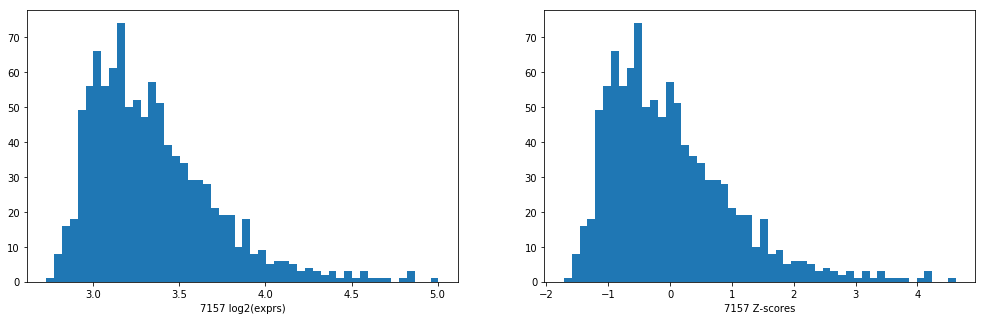

In [38]:
gene =  7157#5701#2625#3169 7157
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
tmp = plt.hist(gdsc_exprs.loc[gene,:], bins =50)
tmp= plt.xlabel(str(gene)+" log2(exprs)")
plt.subplot(1,2,2)
tmp = plt.hist(gdsc_exprs_z.loc[gene,:], bins =50)
tmp= plt.xlabel(str(gene)+" Z-scores")

### CNA and mutations 

In [13]:
print("CNA profiles with response in GDSC:")
gdsc_cna = pd.read_csv(preprocessed_data+"/CNA/"+"GDSC.Segment_Mean.CNA.tsv",sep = "\t",index_col=0)
gdsc_cna.rename(int,axis="columns",inplace=True)
for drug in gdsc_drugs:

    r = pd.read_csv(preprocessed_data+"/annotations/"+"GDSC_response."+drug+".tsv",
                           sep = "\t",index_col=0)

    shared_samples = sorted(list(set(r.index.values).intersection(set(gdsc_cna.columns.values))))
    cna = gdsc_cna.loc[:,shared_samples]
    gdsc_responses_cna = r.loc[shared_samples,:]
    # save samples with multi-omics profiles ands responses available
    gdsc_responses_multiomics[drug]["CNA"] = gdsc_responses_cna
    #cna.to_csv(root_dir+"/CNA/" +"GDSC_CNA."+drug+".tsv", sep = "\t")
    #r.to_csv(root_dir+"/response/"+"GDSC_response.CNA."+drug+".tsv", sep = "\t")

    R = gdsc_responses_cna.loc[gdsc_responses_cna["response"]=="R",:].shape[0]
    S = gdsc_responses_cna.loc[gdsc_responses_cna["response"]=="S",:].shape[0]
    print(drug, gdsc_responses_cna.shape[0],"R:",R,"S:",S)
    if not cna.shape[1]==gdsc_responses_cna.shape[0] == len(shared_samples):
        print(cna.shape[1],gdsc_responses_cna.shape[0], len(shared_samples),file=sys.stderr)


CNA profiles with response in GDSC:
Cisplatin 846 R: 767 S: 79
Cetuximab 868 R: 745 S: 123
Gemcitabine 865 R: 811 S: 54
Bortezomib 402 R: 371 S: 31
Tamoxifen 923 R: 816 S: 107
Gefitinib 842 R: 723 S: 119
5-Fluorouracil 911 R: 817 S: 94
Afatinib 845 R: 692 S: 153
Paclitaxel 402 R: 376 S: 26
Docetaxel 846 R: 780 S: 66
Lapatinib 398 R: 337 S: 61
Erlotinib 372 R: 308 S: 64


In [14]:
print("Point mutations with response in GDSC:")
gdsc_mut = pd.read_csv(preprocessed_data+"/mutations/"+"GDSC.non_bin_mutations.tsv",sep = "\t",index_col=0)
gdsc_mut.rename(int,axis="columns",inplace=True)
for drug in gdsc_drugs:
    r = pd.read_csv(preprocessed_data+"/annotations/"+"GDSC_response."+drug+".tsv",
                           sep = "\t",index_col=0)

    shared_samples = sorted(list(set(r.index.values).intersection(set(gdsc_mut.columns.values))))

    mut = gdsc_mut.loc[:,shared_samples]
    gdsc_responses_mut = r.loc[shared_samples,:]
    # save samples with multi-omics profiles ands responses available
    gdsc_responses_multiomics[drug]["mutations"] = gdsc_responses_mut
    #mut.to_csv(root_dir+"/mutations/" +"GDSC_mutations."+drug+".tsv", sep = "\t")

    R = gdsc_responses_mut.loc[gdsc_responses_mut["response"]=="R",:].shape[0]
    S = gdsc_responses_mut.loc[gdsc_responses_mut["response"]=="S",:].shape[0]
    print(drug, gdsc_responses_mut.shape[0],"R:",R,"S:",S)

    if not mut.shape[1]==gdsc_responses_mut.shape[0] == len(shared_samples):
        print(mut.shape[1],gdsc_responses_mut.shape[0], len(shared_samples),file=sys.stderr)


Point mutations with response in GDSC:
Cisplatin 850 R: 771 S: 79
Cetuximab 873 R: 749 S: 124
Gemcitabine 870 R: 815 S: 55
Bortezomib 402 R: 371 S: 31
Tamoxifen 928 R: 820 S: 108
Gefitinib 846 R: 727 S: 119
5-Fluorouracil 916 R: 822 S: 94
Afatinib 849 R: 696 S: 153
Paclitaxel 402 R: 376 S: 26
Docetaxel 850 R: 784 S: 66
Lapatinib 398 R: 337 S: 61
Erlotinib 372 R: 308 S: 64


In [16]:
print("GDSC samples with all multi-OMICs and responses")
for drug in gdsc_drugs:
    r = pd.read_csv(preprocessed_data+"/annotations/"+"GDSC_response."+drug+".tsv",
                           sep = "\t",index_col=0)
    
    exprs_samples = gdsc_responses_multiomics[drug]["exprs"].index.values
    cna_samples = gdsc_responses_multiomics[drug]["CNA"].index.values
    mut_samples = gdsc_responses_multiomics[drug]["mutations"].index.values
    
    r["exprs"] = 0
    r.loc[exprs_samples,'exprs'] =1
    r["CNA"]= 0
    r.loc[cna_samples,'CNA'] =1
    r["mutations"]= 0
    r.loc[mut_samples,'mutations'] =1
    r = r.loc[r[['exprs',"CNA","mutations"]].sum(axis =1)==3,:]
    r.to_csv(root_dir+"/response/"+"GDSC_response."+drug+".tsv", sep = "\t")
    shared_samples = r.index.values
    # expession
    gdsc_exprs.loc[:,shared_samples].to_csv(root_dir+"/exprs/" +"GDSC_exprs."+drug+".tsv", sep = "\t")
    gdsc_exprs_z.loc[:,shared_samples].to_csv(root_dir+"/exprs/" +"GDSC_exprs.z."+drug+".tsv", sep = "\t")
    # CNA
    gdsc_cna.loc[:,shared_samples].to_csv(root_dir+"/CNA/" +"GDSC_CNA."+drug+".tsv", sep = "\t")
    # mutations
    gdsc_mut.loc[:,shared_samples].to_csv(root_dir+"/mutations/" +"GDSC_mutations."+drug+".tsv", sep = "\t")
    
    R, S = r.loc[r["response"]=="R",:].shape[0], r.loc[r["response"]=="S",:].shape[0]
    print(drug, r.shape[0],"R:",R,"S:",S)
    
    
    

GDSC samples with all multi-OMICs and responses
Cisplatin 829 R: 752 S: 77
Cetuximab 856 R: 735 S: 121
Gemcitabine 844 R: 790 S: 54
Bortezomib 391 R: 360 S: 31
Tamoxifen 908 R: 801 S: 107
Gefitinib 825 R: 710 S: 115
5-Fluorouracil 889 R: 797 S: 92
Afatinib 828 R: 678 S: 150
Paclitaxel 389 R: 363 S: 26
Docetaxel 829 R: 764 S: 65
Lapatinib 387 R: 326 S: 61
Erlotinib 362 R: 298 S: 64


# Testing datasets

## Clinical Trials

In [14]:
for row in pd.read_csv(root_dir+"datasets.tsv",sep = "\t").iterrows():
    drug = row[1]["drug"]
    r = row[1]["ID"]+"_response."+drug+".tsv"
    #print(row[1]["ID"],row[1]["expression"],drug,r)
    e = pd.read_csv(preprocessed_data+"/exprs/"+row[1]["expression"],sep="\t",index_col=0)
    r = pd.read_csv(preprocessed_data+"/annotations/"+r,sep="\t",index_col=0)
    shared_samples = sorted(list(set(r.index.values).intersection(set(e.columns.values))))
    e = e.loc[:,shared_samples]
    e.index.name = gene_id
    e.sort_index(inplace = True)
    e.to_csv(root_dir+"/exprs/"+row[1]["ID"]+"_exprs."+drug+".tsv", sep = "\t")
    e_z = (e.T - e.T.mean())/e.T.std()
    e_z.T.to_csv(root_dir+"/exprs/"+row[1]["ID"]+"_exprs.z."+drug+".tsv", sep = "\t")
    r = r.loc[shared_samples,:]
    r.to_csv(root_dir+"/response/"+row[1]["ID"]+"_response."+drug+".tsv", sep = "\t")
    R, S = r.loc[r["response"]=="R",:].shape[0], r.loc[r["response"]=="S",:].shape[0]
    print(drug, len(shared_samples),"R:",R,"S:",S)

Docetaxel 24 R: 14 S: 10
Cisplatin 24 R: 8 S: 16
Docetaxel 51 R: 5 S: 46
Paclitaxel 84 R: 26 S: 58
Erlotinib 25 R: 12 S: 13
Bortezomib 169 R: 84 S: 85
Bortezomib 169 R: 84 S: 85


# PDX 

    * Tamoxifen must be excluded because no S samples were in this cohor t 
    * 5-Fluorouracil cohort has just 1 S sample

### expressions 

In [19]:
# store samples with multi-omics profiles an responses available
pdx_responses_multiomics = {}
pdx_exprs = pd.read_csv(preprocessed_data+"/exprs/"+"PDX.FPKM2TPMplus1log2.Expr.tsv",sep="\t",index_col=0)
pdx_exprs_z = (pdx_exprs.T - pdx_exprs.T.mean())/pdx_exprs.T.std()
pdx_exprs_z = pdx_exprs_z.T

for drug in ["Cetuximab","Paclitaxel","Gemcitabine","5-Fluorouracil","Erlotinib"]:
    r = pd.read_csv(preprocessed_data+"/annotations/"+"PDX_response."+drug+".tsv",
                           sep = "\t",index_col=0)
    shared_samples = sorted(list(set(r.index.values).intersection(set(pdx_exprs.columns.values))))
    pdx_responses_exprs = r.loc[shared_samples,:]
    pdx_responses_multiomics[drug] = {"exprs":pdx_responses_exprs}
    e = pdx_exprs.loc[:,shared_samples]
    e.index.name = gene_id
    #e.to_csv(root_dir+"/exprs/"+"PDX_exprs."+drug+".tsv", sep = "\t")
    e_z = pdx_exprs_z.loc[:,shared_samples]
    #e_z.to_csv(root_dir+"/exprs/"+"PDX_exprs.z."+drug+".tsv", sep = "\t")
    pdx_responses_exprs.to_csv(root_dir+"/response/"+"PDX_response."+drug+".tsv", sep = "\t")
    R = pdx_responses_exprs.loc[pdx_responses_exprs["response"]=="R",:].shape[0]
    S = pdx_responses_exprs.loc[pdx_responses_exprs["response"]=="S",:].shape[0]
    print(drug, pdx_responses_exprs.shape[0],"R:",R,"S:",S)

Cetuximab 60 R: 55 S: 5
Paclitaxel 43 R: 38 S: 5
Gemcitabine 25 R: 18 S: 7
5-Fluorouracil 23 R: 22 S: 1
Erlotinib 21 R: 18 S: 3


### CNA and mutations

In [20]:
pdx_cna = pd.read_csv(preprocessed_data+"/CNA/"+"PDX.Segment_Mean.CNA.tsv",sep="\t",index_col=0)

for drug in ["Cetuximab","Paclitaxel","Gemcitabine","5-Fluorouracil","Erlotinib"]:
    r = pd.read_csv(preprocessed_data+"/annotations/"+"PDX_response."+drug+".tsv",
                           sep = "\t",index_col=0)
    
    shared_samples = sorted(list(set(r.index.values).intersection(set(pdx_cna.columns.values))))
    #print(drug,"with response",r.shape[0],"with Expressions:",e.shape[1],"Shared samples",len(shared_samples))
    pdx_responses_cna = r.loc[shared_samples,:]
    pdx_responses_multiomics[drug]["CNA"] = pdx_responses_cna
    cna = pdx_cna.loc[:,shared_samples]
    cna.index.name = gene_id
    #cna.to_csv(root_dir+"/CNA/"+"PDX_CNA."+drug+".tsv", sep = "\t")
    #r.to_csv(root_dir+"/response/"+"PDX_response."+drug+".tsv", sep = "\t")
    R = pdx_responses_cna.loc[pdx_responses_cna["response"]=="R",:].shape[0]
    S = pdx_responses_cna.loc[pdx_responses_cna["response"]=="S",:].shape[0]
    print(drug, pdx_responses_cna.shape[0],"R:",R,"S:",S)

Cetuximab 60 R: 55 S: 5
Paclitaxel 43 R: 38 S: 5
Gemcitabine 25 R: 18 S: 7
5-Fluorouracil 23 R: 22 S: 1
Erlotinib 21 R: 18 S: 3


In [21]:
pdx_mut = pd.read_csv(preprocessed_data+"/mutations/"+"PDX.non_bin_mutations.tsv",sep="\t",index_col=0)

for drug in ["Cetuximab","Paclitaxel","Gemcitabine","5-Fluorouracil","Erlotinib"]:
    r = pd.read_csv(preprocessed_data+"/annotations/"+"PDX_response."+drug+".tsv",
                           sep = "\t",index_col=0)
    
    shared_samples = sorted(list(set(r.index.values).intersection(set(pdx_mut.columns.values))))
    #print(drug,"with response",r.shape[0],"with Expressions:",e.shape[1],"Shared samples",len(shared_samples))
    pdx_responses_mut = r.loc[shared_samples,:]
    pdx_responses_multiomics[drug]["mutations"] = pdx_responses_mut
    mut = pdx_mut.loc[:,shared_samples]
    mut.index.name = gene_id
    #mut.to_csv(root_dir+"/mutations/"+"PDX_mutations."+drug+".tsv", sep = "\t")
    #r.to_csv(root_dir+"/response/"+"PDX_response."+drug+".tsv", sep = "\t")
    R = pdx_responses_mut.loc[pdx_responses_mut["response"]=="R",:].shape[0]
    S = pdx_responses_mut.loc[pdx_responses_mut["response"]=="S",:].shape[0]
    print(drug, pdx_responses_mut.shape[0],"R:",R,"S:",S)

Cetuximab 60 R: 55 S: 5
Paclitaxel 43 R: 38 S: 5
Gemcitabine 25 R: 18 S: 7
5-Fluorouracil 23 R: 22 S: 1
Erlotinib 21 R: 18 S: 3


In [22]:
print("PDX samples with responses")
for drug in ["Cetuximab","Paclitaxel","Gemcitabine","5-Fluorouracil","Erlotinib"]:
    r = pd.read_csv(preprocessed_data+"/annotations/"+"PDX_response."+drug+".tsv",
                           sep = "\t",index_col=0)
    
    R, S = r.loc[r["response"]=="R",:].shape[0], r.loc[r["response"]=="S",:].shape[0]
    print(drug, r.shape[0],"R:",R,"S:",S)

PDX samples with responses
Cetuximab 64 R: 58 S: 6
Paclitaxel 46 R: 40 S: 6
Gemcitabine 26 R: 19 S: 7
5-Fluorouracil 25 R: 24 S: 1
Erlotinib 23 R: 19 S: 4


In [23]:
print("PDX samples with responses and all mutli-OMICs profiles")
for drug in ["Cetuximab","Paclitaxel","Gemcitabine","5-Fluorouracil","Erlotinib"]:
    r = pd.read_csv(preprocessed_data+"/annotations/"+"PDX_response."+drug+".tsv",
                           sep = "\t",index_col=0)
    
    exprs_snames = pdx_responses_multiomics[drug]["exprs"].index.values
    cna_snames = pdx_responses_multiomics[drug]["CNA"].index.values
    mut_snames = pdx_responses_multiomics[drug]["mutations"].index.values
    
    r["exprs"] = 0
    r.loc[exprs_snames,'exprs'] =1
    r["CNA"]= 0
    r.loc[cna_snames,'CNA'] =1
    r["mutations"]= 0
    r.loc[mut_snames,'mutations'] =1
    
    r = r.loc[r[['exprs',"CNA","mutations"]].sum(axis =1)==3,:]
    r.to_csv(root_dir+"/response/"+"PDX_response."+drug+".tsv", sep = "\t")
    # multi-omics
    shared_samples = r.index.values
    pdx_exprs.loc[:,shared_samples].to_csv(root_dir+"/exprs/"+"PDX_exprs."+drug+".tsv", sep = "\t")
    pdx_exprs_z.loc[:,shared_samples].to_csv(root_dir+"/exprs/"+"PDX_exprs.z."+drug+".tsv", sep = "\t")
    pdx_cna.loc[:,shared_samples].to_csv(root_dir+"/CNA/"+"PDX_CNA."+drug+".tsv", sep = "\t")
    pdx_mut.loc[:,shared_samples].to_csv(root_dir+"/mutations/"+"PDX_mutations."+drug+".tsv", sep = "\t")
    R, S = r.loc[r["response"]=="R",:].shape[0], r.loc[r["response"]=="S",:].shape[0]
    print(drug, r.shape[0],"R:",R,"S:",S)

PDX samples with responses and all mutli-OMICs profiles
Cetuximab 60 R: 55 S: 5
Paclitaxel 43 R: 38 S: 5
Gemcitabine 25 R: 18 S: 7
5-Fluorouracil 23 R: 22 S: 1
Erlotinib 21 R: 18 S: 3


# TCGA

 - TCGA samples with single drug response --> testing data
 - TCGA samples without responses --> pre-training
 
### Testing data:
 - match sample and patient names by first 12 symbols. 
      * Some patients have more than one sample - primary and metastatic tumors; metastatic were excluded
      * Some samples represent normal tissue (barcodes 10 and 11) - excluded
      * For some patients two tumor samples available - primary and metastatic (barcode 06) - metastatic samples excluded
 

In [79]:
testing_tcga_samples = [] 
for drug in ['Docetaxel','Cisplatin','Erlotinib','Tamoxifen','Cetuximab','Paclitaxel','Gemcitabine']+["Gefitinib"]:
    print(drug, file = sys.stderr)
    #try:
    r = pd.read_csv(preprocessed_data+"/annotations/"+"TCGA_response."+drug+".tsv",
                       sep = "\t",index_col=0)
    #print(drug, r.shape[0],"R:",r[r["response"]=="R"].shape[0],
    #      "S:",r[r["response"]=="S"].shape[0])

    expr_profiles = []
    expr_profiles_z = []
    exprs_reponse_per_sample = []
    cna_profiles = []
    cna_reponse_per_sample = []
    mut_profiles = []
    mut_reponse_per_sample = []
    
    for cohort in set(r["cohort"].values):
        r_ = r[r["cohort"]==cohort]
        print("\t",cohort,"samples with response:",r_.shape[0])
        #print(cohort, r_.shape[0],"R:",r_[r_["response"]=="R"].shape[0],
        #      "S:",r_[r_["response"]=="S"].shape[0])
###################### exprs ###########################################################
        try:
            e = pd.read_csv(preprocessed_data+"/exprs/"+"TCGA-"+cohort+"_exprs.RSEMscaled_est2TPMplus1log2.tsv",sep = "\t",index_col=0)
            no_data = False
        except:
            print("\t","no expression for cohort", cohort,file = sys.stderr) 
            no_data = True
        if not no_data:
            e_z = (e.T - e.T.mean())/e.T.std()
            e_z = e_z.T
            pat2sample = {}
            for sample_barcode in e.columns.values:
                sname = sample_barcode.split("-")
                patient = "-".join(sname[:3])
                tissue_code = sname[3][:-1]
                if not tissue_code in["10","11","06"]:
                    if patient in r_.index.values:
                        # save patient barcode to exclude it from training cohort
                        testing_tcga_samples.append("-".join(sname[:4]))
                        if patient in pat2sample.keys():
                            pat2sample[patient].append(sample_barcode)
                            print("\t","more than one sample for patient",patient,"from cohort",cohort,file = sys.stderr)
                        else:
                            pat2sample[patient]= [sample_barcode]
            samples = []
            for pat in pat2sample.keys():
                for sample in pat2sample[pat]:
                    samples.append(sample)
                    x = r.loc[pat,["drug","response","measure_of_response","cohort"]]
                    x["bcr_patient_barcode"] = pat
                    x["exprs_sample_barcode"] = sample
                    x.name = sample
                    exprs_reponse_per_sample.append(x)
            expr_profiles.append(e[samples])
            expr_profiles_z.append(e_z[samples])
            print("\t\t","with expression",len(samples))
        
###################### CNA ###########################################################
        try:
            cna = pd.read_csv(preprocessed_data+"/CNA/"+"TCGA-"+cohort+".Segment_Mean.CNA.tsv",sep = "\t",index_col=0)
            no_data = False
        except:
            print("\t","no CNA for cohort", cohort,file = sys.stderr)
            no_data = True
        if not no_data:
            pat2sample = {}
            for sample_barcode in cna.columns.values:
                sname = sample_barcode.split("-")
                patient = "-".join(sname[:3])
                tissue_code = sname[3][:-1]
                if not tissue_code in["10","11","06"]:
                    if patient in r_.index.values:
                        # save patient barcode to exclude it from training cohort
                        testing_tcga_samples.append("-".join(sname[:4]))
                        if patient in pat2sample.keys():
                            pat2sample[patient].append(sample_barcode)
                            print("\t","more than one sample for patient",patient,"from cohort",cohort,file = sys.stderr)
                        else:
                            pat2sample[patient]= [sample_barcode]
            samples = []
            for pat in pat2sample.keys():
                for sample in pat2sample[pat]:
                    samples.append(sample)
                    x = r.loc[pat,["drug","response","measure_of_response","cohort"]]
                    x["bcr_patient_barcode"] = pat
                    x["cna_sample_barcode"] = sample
                    x.name = sample
                    cna_reponse_per_sample.append(x)
            cna_profiles.append(cna[samples])
            print("\t\t","with CNA",len(samples))
        
###################### mutations ###########################################################
        try:
            mut = pd.read_csv(preprocessed_data+"/mutations/"+"TCGA-"+cohort+".non_bin_mutations.tsv",sep = "\t",index_col=0)
            no_data = False
        except:
            print("\t","no mutations for cohort", cohort,file = sys.stderr)
            no_data = True
        if not no_data:
            pat2sample = {}
            for sample_barcode in mut.columns.values:
                sname = sample_barcode.split("-")
                patient = "-".join(sname[:3])
                tissue_code = sname[3][:-1]
                if not tissue_code in["10","11","06"]:
                    if patient in r_.index.values:
                        # save patient barcode to exclude it from training cohort
                        testing_tcga_samples.append("-".join(sname[:4]))
                        if patient in pat2sample.keys():
                            pat2sample[patient].append(sample_barcode)
                            print("\t","more than one sample for patient",patient,"from cohort",cohort,file = sys.stderr)
                        else:
                            pat2sample[patient]= [sample_barcode]
            samples = []
            for pat in pat2sample.keys():
                for sample in pat2sample[pat]:
                    samples.append(sample)
                    x = r.loc[pat,["drug","response","measure_of_response","cohort"]]
                    x["bcr_patient_barcode"] = pat
                    x.name = sample
                    x["mut_sample_barcode"] = sample
                    mut_reponse_per_sample.append(x)
            mut_profiles.append(mut[samples])
            print("\t\t","with mutations",len(samples))
        
    exprs_reponse_per_sample = pd.concat(exprs_reponse_per_sample,axis=1).T
    exprs_reponse_per_sample.sort_index(inplace=True)
    #exprs_reponse_per_sample.to_csv(root_dir+"/response/"+"TCGA_response."+drug+".tsv", sep = "\t")
    expr_profiles = pd.concat(expr_profiles,axis=1)
    expr_profiles_z = pd.concat(expr_profiles_z,axis=1)
    expr_profiles.rename(lambda x: x[:16], axis="columns", inplace=True)
    expr_profiles.sort_index(axis=1,inplace=True)
    expr_profiles_z.rename(lambda x: x[:16], axis="columns", inplace=True)
    expr_profiles_z.sort_index(axis=1,inplace=True)
    if exprs_reponse_per_sample.shape[0]!=expr_profiles.shape[1]:
        print(drug, exprs_reponse_per_sample.shape[0],expr_profiles.shape[1],file=sys.stderr)
    print(drug,"Response:",r.shape[0])
    print(drug,"Expression:", exprs_reponse_per_sample.shape[0],
          "R:",exprs_reponse_per_sample.loc[exprs_reponse_per_sample["response"]=="R"].shape[0],
         "S:",exprs_reponse_per_sample.loc[exprs_reponse_per_sample["response"]=="S"].shape[0])
    ##### CNA and mutations #####################
    cna_profiles = pd.concat(cna_profiles,axis=1)
    cna_profiles.rename(lambda x: x[:16], axis="columns", inplace=True)
    cna_profiles.sort_index(axis=1,inplace=True)
    mut_profiles = pd.concat(mut_profiles,axis=1)
    # because some genes were mutated not in ll cohorts NA values appear
    mut_profiles.fillna(0,inplace=True)
    mut_profiles.rename(lambda x: x[:16], axis="columns", inplace=True)
    mut_profiles.sort_index(axis=1,inplace=True)
    ########## multi-omics responses ############
    cna_reponse_per_sample = pd.concat(cna_reponse_per_sample,axis=1).T
    cna_reponse_per_sample.sort_index(inplace=True)
    mut_reponse_per_sample = pd.concat(mut_reponse_per_sample,axis=1).T
    mut_reponse_per_sample.sort_index(inplace=True)
    #exprs_reponse_per_sample.columns
    print(drug,"CNA:", cna_reponse_per_sample.shape[0],
          "R:",cna_reponse_per_sample.loc[cna_reponse_per_sample["response"]=="R"].shape[0],
         "S:",cna_reponse_per_sample.loc[cna_reponse_per_sample["response"]=="S"].shape[0])
    print(drug, "mutations:", mut_reponse_per_sample.shape[0],
          "R:",mut_reponse_per_sample.loc[mut_reponse_per_sample["response"]=="R"].shape[0],
         "S:",mut_reponse_per_sample.loc[mut_reponse_per_sample["response"]=="S"].shape[0])
        #mut_reponse_per_sample.to_csv(root_dir+"/response/"+"TCGA_response."+drug+".tsv", sep = "\t")
    
    exprs_reponse_per_sample.rename(lambda x: x[:12],axis="index",inplace=True)
    cna_reponse_per_sample.rename(lambda x: x[:12],axis="index",inplace=True)
    mut_reponse_per_sample.rename(lambda x: x[:12],axis="index",inplace=True)

    multi_omics_reponse_per_sample = pd.concat([r[["cohort","drug","response","measure_of_response"]],
               exprs_reponse_per_sample[["exprs_sample_barcode"]],
              cna_reponse_per_sample[["cna_sample_barcode"]],
              mut_reponse_per_sample[["mut_sample_barcode"]]],axis=1,sort=True)
    multi_omics_reponse_per_sample["patient"] = multi_omics_reponse_per_sample.index.values

    multi_omics_reponse_per_sample.dropna(subset=["exprs_sample_barcode","cna_sample_barcode","mut_sample_barcode"],inplace=True)
    samples = multi_omics_reponse_per_sample[["exprs_sample_barcode","cna_sample_barcode","mut_sample_barcode"]].applymap(lambda x: x[:16])
    if not multi_omics_reponse_per_sample.shape[0] == samples.loc[samples["exprs_sample_barcode"] == samples["cna_sample_barcode"], :].shape[0] == samples.loc[samples["exprs_sample_barcode"] == samples["mut_sample_barcode"], :].shape[0]:
        print("Sample names in expression, CNA and SNA matrices do not match",file = sys.stderr)
    else:
        multi_omics_reponse_per_sample["sample"] = samples["exprs_sample_barcode"] 
        multi_omics_reponse_per_sample= multi_omics_reponse_per_sample[["sample","patient","cohort","drug","response","measure_of_response",
                                                                       "exprs_sample_barcode","cna_sample_barcode","mut_sample_barcode"]]
        multi_omics_reponse_per_sample.set_index("sample",inplace=True)
    
    ###### write tables ###########
    # multi-OMICs responses
    multi_omics_reponse_per_sample.to_csv(root_dir+"/response/"+"TCGA_response."+drug+".tsv", sep = "\t")  
    # expressions
    expr_profiles = expr_profiles.loc[:,multi_omics_reponse_per_sample.index.values]
    expr_profiles.to_csv(root_dir+"/exprs/"+"TCGA_exprs."+drug+".tsv", sep = "\t")
    expr_profiles_z = expr_profiles_z.loc[:,multi_omics_reponse_per_sample.index.values]
    expr_profiles_z.to_csv(root_dir+"/exprs/"+"TCGA_exprs.z."+drug+".tsv", sep = "\t")
    # cna
    cna_profiles = cna_profiles.loc[:,multi_omics_reponse_per_sample.index.values]
    cna_profiles.to_csv(root_dir+"/CNA/"+"TCGA_CNA."+drug+".tsv", sep = "\t")
    # mutations
    mut_profiles = mut_profiles.loc[:,multi_omics_reponse_per_sample.index.values]
    mut_profiles.to_csv(root_dir+"/mutations/"+"TCGA_mutations."+drug+".tsv", sep = "\t")
    print(drug, "samples with multi-OMICs+response",multi_omics_reponse_per_sample.shape[0],
          "R:",multi_omics_reponse_per_sample.loc[multi_omics_reponse_per_sample["response"]=="R"].shape[0],
          "S:",multi_omics_reponse_per_sample.loc[multi_omics_reponse_per_sample["response"]=="S"].shape[0])
    

Docetaxel


	 LUSC samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 0
	 SARC samples with response: 2
		 with expression 2
		 with CNA 2
		 with mutations 2
	 BLCA samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 1
	 STAD samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 1
	 HNSC samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 1
	 LUAD samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 3
	 BRCA samples with response: 10
		 with expression 10
		 with CNA 9
		 with mutations 9
Docetaxel Response: 21
Docetaxel Expression: 21 R: 12 S: 9
Docetaxel CNA: 20 R: 12 S: 8
Docetaxel mutations: 17 R: 8 S: 9
Docetaxel samples with multi-OMICs+response 16 R: 8 S: 8
	 CESC samples with response: 54


Cisplatin


		 with expression 52
		 with CNA 53
		 with mutations 20
	 UCS samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 3
	 LUSC samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 0
	 SARC samples with response: 2
		 with expression 2
		 with CNA 2
		 with mutations 2
	 MESO samples with response: 5
		 with expression 5
		 with CNA 5
	 BLCA samples with response: 1


	 no mutations for cohort MESO


		 with expression 1
		 with CNA 1
		 with mutations 1
	 STAD samples with response: 5
		 with expression 5
		 with CNA 5
		 with mutations 3
	 HNSC samples with response: 38
		 with expression 38
		 with CNA 38
		 with mutations 37
	 SKCM samples with response: 1
		 with expression 0
		 with CNA 0
		 with mutations 0
	 UCEC samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 0
Cisplatin Response: 113
Cisplatin Expression: 110 R: 19 S: 91
Cisplatin CNA: 111 R: 19 S: 92
Cisplatin mutations: 66 R: 6 S: 60
Cisplatin samples with multi-OMICs+response 66 R: 6 S: 60
	 BLCA samples with response: 1


Erlotinib


		 with expression 1
		 with CNA 1
		 with mutations 0
	 PAAD samples with response: 1
		 with expression 0
		 with CNA 1
		 with mutations 1
	 LUAD samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 3
	 LUSC samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 0
Erlotinib Response: 6
Erlotinib Expression: 5 R: 3 S: 2
Erlotinib CNA: 6 R: 4 S: 2
Erlotinib mutations: 4 R: 3 S: 1
Erlotinib samples with multi-OMICs+response 3 R: 2 S: 1
	 BRCA samples with response: 14


Tamoxifen


		 with expression 14
		 with CNA 14
		 with mutations 13
	 SKCM samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 0
Tamoxifen Response: 15
Tamoxifen Expression: 15 R: 3 S: 12
Tamoxifen CNA: 15 R: 3 S: 12
Tamoxifen mutations: 13 R: 3 S: 10
Tamoxifen samples with multi-OMICs+response 13 R: 3 S: 10
	 HNSC samples with response: 10


Cetuximab


		 with expression 10
		 with CNA 10
		 with mutations 10
Cetuximab Response: 10
Cetuximab Expression: 10 R: 4 S: 6
Cetuximab CNA: 10 R: 4 S: 6
Cetuximab mutations: 10 R: 4 S: 6
Cetuximab samples with multi-OMICs+response 10 R: 4 S: 6
	 CESC samples with response: 1


Paclitaxel


		 with expression 1
		 with CNA 1
		 with mutations 0
	 UCS samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 3
	 LUSC samples with response: 2
		 with expression 2
		 with CNA 2
		 with mutations 0
	 BLCA samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 0
	 STAD samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 1
	 HNSC samples with response: 2
		 with expression 2
		 with CNA 2
		 with mutations 1
	 LUAD samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 3
	 BRCA samples with response: 33
		 with expression 33
		 with CNA 33
		 with mutations 27
	 UCEC samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 0
Paclitaxel Response: 49
Paclitaxel Expression: 49 R: 15 S: 34
Paclitaxel CNA: 49 R: 15 S: 34
Paclitaxel mutations: 35 R: 10 S: 25
Paclitaxel samples with multi-OMICs+response 35 R: 10 S: 25
	 CESC samples with response: 1


Gemcitabine


		 with expression 1
		 with CNA 1
		 with mutations 0
	 PAAD samples with response: 50
		 with expression 48
		 with CNA 50
		 with mutations 49
	 LUSC samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 1
	 SARC samples with response: 3
		 with expression 3
		 with CNA 3
		 with mutations 3
	 LIHC samples with response: 2
		 with expression 2
		 with CNA 2
		 with mutations 2
	 BLCA samples with response: 5
		 with expression 5
		 with CNA 5
		 with mutations 1
	 UCEC samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 0
	 LUAD samples with response: 2
		 with expression 2
		 with CNA 2
		 with mutations 2
	 PCPG samples with response: 1
		 with expression 1
		 with CNA 1
		 with mutations 1
Gemcitabine Response: 68
Gemcitabine Expression: 66 R: 41 S: 25
Gemcitabine CNA: 68 R: 43 S: 25
Gemcitabine mutations: 59 R: 38 S: 21
Gemcitabine samples with multi-OMICs+response 57 R: 36 S: 21
	 LUAD samples with response: 2


Gefitinib


		 with expression 2
		 with CNA 2
		 with mutations 2
Gefitinib Response: 2
Gefitinib Expression: 2 R: 2 S: 0
Gefitinib CNA: 2 R: 2 S: 0
Gefitinib mutations: 2 R: 2 S: 0
Gefitinib samples with multi-OMICs+response 2 R: 2 S: 0


In [17]:
testing_tcga_samples = set(testing_tcga_samples)
print(len(testing_tcga_samples), "TCGA samples in testing cohort will be excluded from pre-training, e.g.:",list(testing_tcga_samples)[:3])

265 TCGA samples in testing cohort will be excluded from pre-training, e.g.: ['TCGA-HD-8224-01A', 'TCGA-EK-A2H0-01A', 'TCGA-VS-A958-01A']


### Pre-training datasets
TCGA samples other than testing

In [45]:
# save only tumor samples for pre-training dataset 
pre_training_expr_samples = set([])
tcga_cohorts  = ["ACC", "BLCA", "BRCA", "CESC", "CHOL", "COAD", "DLBC", "ESCA", 
             "GBM", "HNSC", "KICH", "KIRC", "KIRP", "LAML", "LGG", "LIHC", 
             "LUAD", "LUSC", "MESO", "OV", "PAAD", "PCPG", "PRAD", "READ", "SARC", "SKCM",  
             "STES", "TGCT", "THCA", "THYM", "UCEC", "UCS", "UVM"]
for cohort in tcga_cohorts:
    
    tcga_exprs = pd.read_csv(preprocessed_data+"/exprs/"+"TCGA-"+cohort+"_exprs.RSEMscaled_est2TPMplus1log2.tsv",sep = "\t",index_col=0)
    normal_samples = []
    for sample_barcode in tcga_exprs.columns.values:
        sname = sample_barcode.split("-")
        tissue_code = sname[3][:-1]
        if tissue_code in["10","11"]:
            normal_samples.append(sample_barcode)
    tcga_exprs_norm = tcga_exprs.loc[:,tcga_exprs.columns.isin(normal_samples)]
    tcga_exprs_norm.to_csv(root_dir+"/exprs/"+"TCGA-"+cohort+"_normal_exprs.tsv", sep = "\t")
    
    tcga_exprs = tcga_exprs.loc[:,~tcga_exprs.columns.isin(normal_samples)]
    print(cohort,tcga_exprs_norm.shape[1],"normal samples", tcga_exprs.shape[1],"tumor samples")
    tcga_exprs.rename(lambda x : x[:16],axis = "columns", inplace=True)
    dups = tcga_exprs.columns[tcga_exprs.columns.duplicated()]
    if len(dups) > 0:
        print(cohort,len(dups),"sample names duplicated",dups,file = sys.stderr )
        
    tcga_exprs_z = (tcga_exprs.T - tcga_exprs.T.mean())/tcga_exprs.T.std() 
    tcga_exprs_z = tcga_exprs_z.T
    ##### exclude testing samples
    test_samples_exclude =[]
    for sname in tcga_exprs.columns.values:
        for test_sname in testing_tcga_samples:
            if sname[:12] == test_sname[:12]:
                test_samples_exclude.append(sname)
    if len(test_samples_exclude) > 0:
        print(len(test_samples_exclude),"samples belonging to patients from testing cohort excluded\n",file= sys.stderr)
        tcga_exprs = tcga_exprs.loc[:,~tcga_exprs.columns.isin(test_samples_exclude)]
    ##### save names of pre-training samples 
    pre_training_expr_samples = pre_training_expr_samples | set(tcga_exprs.columns.values)
    tcga_exprs.to_csv(root_dir+"/exprs/"+"TCGA-"+cohort+"_exprs.tsv", sep = "\t")
    e_z = tcga_exprs_z.loc[:,tcga_exprs.columns.values]
    e_z.to_csv(root_dir+"/exprs/"+"TCGA-"+cohort+"_exprs.z.tsv", sep = "\t")
print("TCGA pre-training samples with expression:", len(pre_training_expr_samples))

ACC 0 normal samples 79 tumor samples
BLCA 19 normal samples 408 tumor samples


25 samples belonging to patients from testing cohort excluded



BRCA 112 normal samples 1100 tumor samples


162 samples belonging to patients from testing cohort excluded



CESC 3 normal samples 306 tumor samples


129 samples belonging to patients from testing cohort excluded



CHOL 9 normal samples 36 tumor samples
COAD 41 normal samples 287 tumor samples
DLBC 0 normal samples 48 tumor samples
ESCA 11 normal samples 185 tumor samples
GBM 5 normal samples 166 tumor samples
HNSC 44 normal samples 522 tumor samples


154 samples belonging to patients from testing cohort excluded



KICH 25 normal samples 66 tumor samples
KIRC 72 normal samples 534 tumor samples
KIRP 32 normal samples 291 tumor samples
LAML 0 normal samples 173 tumor samples
LGG 0 normal samples 530 tumor samples
LIHC 50 normal samples 373 tumor samples


6 samples belonging to patients from testing cohort excluded



LUAD 59 normal samples 517 tumor samples


39 samples belonging to patients from testing cohort excluded



LUSC 51 normal samples 501 tumor samples


17 samples belonging to patients from testing cohort excluded



MESO 0 normal samples 87 tumor samples


10 samples belonging to patients from testing cohort excluded



OV 0 normal samples 307 tumor samples
PAAD 4 normal samples 179 tumor samples


143 samples belonging to patients from testing cohort excluded



PCPG 3 normal samples 184 tumor samples


3 samples belonging to patients from testing cohort excluded



PRAD 52 normal samples 498 tumor samples
READ 10 normal samples 95 tumor samples
SARC 2 normal samples 263 tumor samples


21 samples belonging to patients from testing cohort excluded



SKCM 1 normal samples 472 tumor samples


2 samples belonging to patients from testing cohort excluded



STES 46 normal samples 600 tumor samples


19 samples belonging to patients from testing cohort excluded



TGCT 0 normal samples 156 tumor samples
THCA 59 normal samples 509 tumor samples
THYM 2 normal samples 120 tumor samples
UCEC 24 normal samples 177 tumor samples


14 samples belonging to patients from testing cohort excluded



UCS 0 normal samples 57 tumor samples


18 samples belonging to patients from testing cohort excluded



UVM 0 normal samples 80 tumor samples
TCGA pre-training samples with expression: 9459


### CNA and Mutations 

We cut tumor barcodes to first 16 signs, because otherwise they do not match between expression, CNA and SNA matrices. 

    'TCGA-PC-A5DO-01A-11R-A26T-07' -> 'TCGA-PC-A5DO-01A'
    'TCGA-PC-A5DO-01A-11R-A26T-07' -> 'TCGA-PC-A5DO-01A'

Last signs int the barcode encode vial etc. 


In [19]:
# save only tumor samples for pre-training dataset 
pre_training_cna_samples = set([])
                                
for cohort in tcga_cohorts:
    
    tcga_cna = pd.read_csv(preprocessed_data+"/CNA/"+"TCGA-"+cohort+".Segment_Mean.CNA.tsv",sep = "\t",index_col=0)
    normal_samples = []
    for sample_barcode in tcga_cna.columns.values:
        sname = sample_barcode.split("-")
        tissue_code = sname[3][:-1]
        if tissue_code in["10","11"]:
            normal_samples.append(sample_barcode)
    tcga_cna_norm = tcga_cna.loc[:,tcga_cna.columns.isin(normal_samples)]
    #tcga_cna_norm.to_csv(root_dir+"/CNA/"+"TCGA-"+cohort+"_normal_CNA.tsv", sep = "\t")
    tcga_cna = tcga_cna.loc[:,~tcga_cna.columns.isin(normal_samples)]
    dups = tcga_cna.columns[tcga_cna.columns.duplicated()]
    if len(dups) > 0:
            print(cohort,len(dups),"sample names duplicated",dups,file = sys.stderr )
    tcga_cna.rename(lambda x : x[:16],axis = "columns", inplace=True)
    ##### exclude testing samples
    test_samples_exclude =[]
    for sname in tcga_cna.columns.values:
        for test_sname in testing_tcga_samples:
            if sname[:12] == test_sname[:12]:
                test_samples_exclude.append(sname)
    if len(test_samples_exclude) > 0:
        print(len(test_samples_exclude),"samples belonging to patients from testing cohort excluded",file= sys.stderr)
        tcga_cna = tcga_cna.loc[:,~tcga_cna.columns.isin(test_samples_exclude)]
    ##### save names of pre-training samples 
    pre_training_cna_samples  = pre_training_cna_samples |  set(tcga_cna.columns.values)
    print(cohort,tcga_cna_norm.shape[1],"normal samples", tcga_cna.shape[1],"tumor samples")
    tcga_cna.to_csv(root_dir+"/CNA/"+"TCGA-"+cohort+"_CNA.tsv", sep = "\t")
print("TCGA pre-training samples with CNA:", len(pre_training_cna_samples))

ACC 0 normal samples 90 tumor samples


10 samples belonging to patients from testing cohort excluded


BLCA 5 normal samples 399 tumor samples


48 samples belonging to patients from testing cohort excluded


BRCA 1 normal samples 1039 tumor samples


56 samples belonging to patients from testing cohort excluded


CESC 0 normal samples 241 tumor samples
CHOL 0 normal samples 36 tumor samples
COAD 0 normal samples 453 tumor samples
DLBC 0 normal samples 52 tumor samples
ESCA 0 normal samples 185 tumor samples
GBM 0 normal samples 590 tumor samples


50 samples belonging to patients from testing cohort excluded


HNSC 6 normal samples 474 tumor samples
KICH 0 normal samples 66 tumor samples
KIRC 0 normal samples 529 tumor samples
KIRP 0 normal samples 288 tumor samples
LAML 0 normal samples 191 tumor samples
LGG 1 normal samples 529 tumor samples


2 samples belonging to patients from testing cohort excluded


LIHC 1 normal samples 370 tumor samples


10 samples belonging to patients from testing cohort excluded


LUAD 0 normal samples 508 tumor samples


5 samples belonging to patients from testing cohort excluded


LUSC 0 normal samples 496 tumor samples


5 samples belonging to patients from testing cohort excluded


MESO 0 normal samples 82 tumor samples
OV 0 normal samples 597 tumor samples


51 samples belonging to patients from testing cohort excluded


PAAD 0 normal samples 134 tumor samples


1 samples belonging to patients from testing cohort excluded


PCPG 2 normal samples 165 tumor samples
PRAD 0 normal samples 493 tumor samples
READ 0 normal samples 166 tumor samples


7 samples belonging to patients from testing cohort excluded


SARC 2 normal samples 254 tumor samples


1 samples belonging to patients from testing cohort excluded


SKCM 1 normal samples 470 tumor samples


7 samples belonging to patients from testing cohort excluded


STES 1 normal samples 619 tumor samples
TGCT 0 normal samples 156 tumor samples
THCA 0 normal samples 506 tumor samples
THYM 0 normal samples 125 tumor samples


6 samples belonging to patients from testing cohort excluded


UCEC 0 normal samples 534 tumor samples


6 samples belonging to patients from testing cohort excluded


UCS 0 normal samples 50 tumor samples
UVM 0 normal samples 80 tumor samples
TCGA pre-training samples with CNA: 10782


In [20]:
pre_training_mut_samples = set([])
                                
for cohort in tcga_cohorts:
    try:
        tcga_mut = pd.read_csv(preprocessed_data+"/mutations/"+"TCGA-"+cohort+".non_bin_mutations.tsv",sep = "\t",index_col=0)
        normal_samples = []
        for sample_barcode in tcga_mut.columns.values:
            sname = sample_barcode.split("-")
            tissue_code = sname[3][:-1]
            if tissue_code in["10","11"]:
                normal_samples.append(sample_barcode)
        tcga_mut_norm = tcga_mut.loc[:,tcga_mut.columns.isin(normal_samples)]
        #tcga_mut_norm.to_csv(root_dir+"/mutations/"+"TCGA-"+cohort+"_normal_mutations.tsv", sep = "\t")
        tcga_mut = tcga_mut.loc[:,~tcga_mut.columns.isin(normal_samples)]
        tcga_mut.rename(lambda x : x[:16],axis = "columns", inplace=True)
        # check duplicates
        dups = tcga_mut.columns[tcga_mut.columns.duplicated()]
        if len(dups) > 0:
            print(cohort,len(dups),"sample names duplicated",dups,file = sys.stderr )
            
        ##### exclude testing samples
        test_samples_exclude =[]
        for sname in tcga_mut.columns.values:
            for test_sname in testing_tcga_samples:
                if sname[:12] == test_sname[:12]:
                    test_samples_exclude.append(sname)
        if len(test_samples_exclude) > 0:
            print(len(test_samples_exclude),"samples belonging to patients from testing cohort excluded",file= sys.stderr)
            tcga_mut = tcga_mut.loc[:,~tcga_mut.columns.isin(test_samples_exclude)]
        ##### save names of pre-training samples 
        pre_training_mut_samples  = pre_training_mut_samples |  set(tcga_mut.columns.values)
        print(cohort,tcga_mut_norm.shape[1],"normal samples", tcga_mut.shape[1],"tumor samples")
        tcga_mut.to_csv(root_dir+"/mutations/"+"TCGA-"+cohort+"_mutations.tsv", sep = "\t")
        
    except:
        print("no mutations for ",cohort,file = sys.stderr)
print("TCGA pre-training samples with point mutations:", len(pre_training_mut_samples))

ACC 0 normal samples 90 tumor samples


3 samples belonging to patients from testing cohort excluded


BLCA 0 normal samples 127 tumor samples


41 samples belonging to patients from testing cohort excluded


BRCA 0 normal samples 941 tumor samples


20 samples belonging to patients from testing cohort excluded


CESC 0 normal samples 174 tumor samples
CHOL 0 normal samples 35 tumor samples
COAD 0 normal samples 154 tumor samples
DLBC 0 normal samples 48 tumor samples
ESCA 0 normal samples 185 tumor samples
GBM 0 normal samples 290 tumor samples


48 samples belonging to patients from testing cohort excluded


HNSC 0 normal samples 464 tumor samples


no mutations for  KICH
no mutations for  KIRC


KIRP 0 normal samples 161 tumor samples
LAML 0 normal samples 197 tumor samples
LGG 0 normal samples 530 tumor samples


2 samples belonging to patients from testing cohort excluded


LIHC 0 normal samples 371 tumor samples


10 samples belonging to patients from testing cohort excluded


LUAD 0 normal samples 533 tumor samples


1 samples belonging to patients from testing cohort excluded


LUSC 0 normal samples 177 tumor samples


no mutations for  MESO
no mutations for  OV
50 samples belonging to patients from testing cohort excluded


PAAD 0 normal samples 135 tumor samples


1 samples belonging to patients from testing cohort excluded


PCPG 0 normal samples 183 tumor samples
PRAD 0 normal samples 499 tumor samples
READ 0 normal samples 69 tumor samples


7 samples belonging to patients from testing cohort excluded


SARC 0 normal samples 240 tumor samples
SKCM 0 normal samples 368 tumor samples


3 samples belonging to patients from testing cohort excluded


STES 0 normal samples 471 tumor samples
TGCT 0 normal samples 155 tumor samples
THCA 0 normal samples 504 tumor samples
THYM 0 normal samples 123 tumor samples
UCEC 0 normal samples 248 tumor samples


6 samples belonging to patients from testing cohort excluded


UCS 0 normal samples 51 tumor samples
UVM 0 normal samples 80 tumor samples
TCGA pre-training samples with point mutations: 7418


In [21]:
pre_training_multi_omics = pre_training_mut_samples.intersection(pre_training_cna_samples).intersection(pre_training_expr_samples)
print("Pretraining samples from TCGA with multi-OMICS profiles:",
      len(pre_training_multi_omics ),file = sys.stderr)

Pretraining samples from TCGA with multi-OMICS profiles: 6505


In [22]:
# create text file with IDs of samples having more than   
fopen = open(response_dir+"/TCGA_pretraining_samples.with_multi-OMICS.txt","w")
print("\n".join(list(pre_training_multi_omics)), file = fopen)
fopen.close()


# CCLE

#### Drugs 
* "Paclitaxel","Erlotinib"

* Target EGFR : 'Erlotinib', 'Lapatinib', 'ZD-6474'

#### Problems:
* cell line names in gene expression matrix are absent in drug response file -> remapped 
* "GSM886946":"COLO-699" and "GSM887546":"RPMI 6666" are absent in annotation CCLE_sample_info_file_2012-10-18.txt

In [85]:
anno = pd.read_csv(root_dir+ "/preprocessed/annotations/CCLE_expessions.annotations.tsv",sep = "\t")
ccle_exprs = pd.read_csv(root_dir+"/preprocessed/exprs/GSE36133.BrainArray.RMAlog2Average.ENTREZID.Expr.tsv", sep ="\t")
anno = anno[["CCLE_name","GSM"]]
anno.set_index("GSM",drop=True,inplace=True)
CCLE_names_dict = anno.to_dict()['CCLE_name']
mapped_CCLE_names = set(ccle_exprs.columns.values).intersection(set(CCLE_names_dict.keys()))
not_mapped_CCLE_names = set(ccle_exprs.columns.values).difference(set(CCLE_names_dict.keys()))
print("mapped sample names:",len(mapped_CCLE_names), "not mapped", not_mapped_CCLE_names)
ccle_exprs = ccle_exprs.loc[:,mapped_CCLE_names]
ccle_exprs.rename(CCLE_names_dict,axis="columns",inplace=True)
ccle_exprs.sort_index(inplace = True)
ccle_exprs.sort_index(inplace = True,axis=1)
ccle_exprs

mapped sample names: 915 not mapped set(['GSM887546', 'GSM886946'])


1321N1_CENTRAL_NERVOUS_SYSTEM  143B_BONE  22RV1_PROSTATE  \
1                               5.899963   5.495630        4.915154   
2                               4.151092   4.867485        4.683452   
9                               7.937206   7.653808       10.551317   
10                              4.153359   4.368691        4.320320   
12                              5.064883   4.265396        4.796432   
13                              3.663302   3.757266        3.603541   
14                              9.389963   9.503278        8.975407   
15                              3.809963   3.618911        3.847564   
16                             11.225556  10.975712       10.803577   
18                              3.953017   4.555593        5.474231   
19                              8.095299   5.296161        4.614722   
20                              5.372560   4.940457        6.076071   
21                              7.210206   6.741976        8.185252   
22                              9.708525   9.813227        9.417609   
23                             10.527121  10.729644        9.057245   
24                              4.631474   4.356246        5.043293   
25                              9.669058   9.261225        8.773533   
26                              3.580251   3.508529        3.661769   
27                              6.616974   7.586944        6.122048   
28                              3.795155   3.431100        3.674707   
29                              6.148654   6.586652        5.607395   
30                              8.693847   8.457447        9.084973   
31                              9.532605   9.587811       10.611718   
32                              5.380618   4.303719        5.291968   
33                              3.689236   4.414916        7.914083   
34                             11.347089  11.365562       12.185121   
35                              4.833916   5.051291        6.274047   
36                              6.813472   6.763118        7.587337   
37                             10.458735  10.927785       11.273740   
38                              9.622090   9.115806        9.600749   
...                                  ...        ...             ...   
107986768                       3.907213   3.615368        4.282710   
107986769                       3.730330   3.586534        3.790452   
107986777                       3.642263   3.275055        3.279163   
107986785                       4.672146   4.200010        5.565766   
107986797                       5.594328   7.785989        5.458347   
107986806                       4.058643   3.932037        4.299911   
107986810                       4.382511   4.384802        4.247668   
107986822                       6.790160   5.784575        6.147889   
107986858                       3.908920   3.693882        4.203444   
107986859                       4.376159   4.279316        4.892932   
107986876                       4.293317   3.891817        3.713781   
107986927                       4.228890   4.191278        4.222070   
107986962                       3.934888   3.955732        7.004557   
107986963                       3.609357   3.464897        3.677171   
107986989                       3.653328   3.313387        3.343658   
107987062                       5.679396   4.283837        6.843327   
107987093                       4.012276   4.501267        4.625787   
107987097                       3.593821   3.718176        3.563286   
107987126                       4.095928   4.321149        4.318859   
107987135                       4.929612   4.903567        4.975591   
107987160                       7.208687   3.364564        3.489351   
107987163                       6.705641   6.674817        6.424433   
107987180                       3.861531   3.617374        3.777230   
107987183                       3.778090   3.718161        3.533250   
107987188                       4.0

In [86]:
ccle_exprs_z =  (ccle_exprs.T - ccle_exprs.T.mean())/ccle_exprs.T.std()
ccle_exprs_z = ccle_exprs_z.T

In [87]:
ccle_exprs_z.shape

(20342, 915)

In [100]:
ccle_exprs_z.loc[:,[u'EFO27_OVARY', u'OVTOKO_OVARY', u'HEYA8_OVARY']].head(3)

EFO27_OVARY  OVTOKO_OVARY  HEYA8_OVARY
1     1.221535     -0.778095    -1.214984
2    -0.378691     -0.333090    -0.483100
9     0.516236      0.706270     0.566283

In [90]:
ccle_response = pd.read_csv(preprocessed_data + "/annotations/"+"CCLE.responses.Paclitaxel_Erlotinib.tsv",sep = "\t",index_col=0)
ccle_response_EGFRi = pd.read_csv(preprocessed_data + "/annotations/"+"CCLE.responses.EGFRi.tsv",sep = "\t",index_col=0)
ccle_response = pd.concat([ccle_response ,ccle_response_EGFRi])
#ccle_response = ccle_response.sort_values()
ccle_response.drop_duplicates(inplace = True)
set(ccle_response["Compound"].values)

{'Erlotinib', 'Lapatinib', 'Paclitaxel', 'ZD-6474'}

In [105]:
# store samples with multi-omics profiles and responses available
ccle_responses_multiomics = {}
print("Samples with expression profiles and response in CCLE:")
for drug in ["Paclitaxel","Erlotinib", 'Lapatinib', 'ZD-6474']:
    r = ccle_response.loc[ccle_response["Compound"]==drug,:]
    
    shared_samples = sorted(list(set(r.index.values).intersection(set(ccle_exprs.columns.values))))
    # save samples with multi-omics profiles an responses available
    ccle_responses_multiomics[drug] = set(shared_samples)
    e = ccle_exprs.loc[:,shared_samples]
    r = r.loc[shared_samples,:]
    e_z = ccle_exprs_z.loc[:,shared_samples]
    #r.to_csv(root_dir+"/response/"+"CCLE_response."+drug+".tsv", sep = "\t")
    #e.to_csv(root_dir+"/exprs/" +"CCLE_exprs."+drug+".tsv", sep = "\t")
    #e_z.to_csv(root_dir+"/exprs/" +"CCLE_exprs.z."+drug+".tsv", sep = "\t")
    
    print(drug, len(shared_samples))

Samples with expression profiles and response in CCLE:
Paclitaxel 471
Erlotinib 471
Lapatinib 472
ZD-6474 464


In [111]:
ccle_cna = pd.read_csv(root_dir+"/preprocessed/CNA/CCLE.Segment_Mean.CNA.tsv", sep ="\t",index_col=0)
print("Samples with CNA profiles and response in CCLE:")
for drug in  ["Paclitaxel","Erlotinib", 'Lapatinib', 'ZD-6474']:
    r = ccle_response.loc[ccle_response["Compound"]==drug,:]
    
    shared_samples = sorted(list(set(r.index.values).intersection(set(ccle_cna.columns.values))))
    # save samples with multi-omics profiles an responses available
    ccle_responses_multiomics[drug] = ccle_responses_multiomics[drug].intersection(set(shared_samples))
    cna = ccle_cna.loc[:,shared_samples]
    r = r.loc[shared_samples,:]
    #cna.to_csv(root_dir+"/CNA/" +"CCLE_CNA."+drug+".tsv", sep = "\t")
    
    print(drug, len(shared_samples))

Samples with CNA profiles and response in CCLE:
Paclitaxel 491
Erlotinib 491
Lapatinib 492
ZD-6474 484


In [112]:
ccle_mut = pd.read_csv(root_dir+"/preprocessed/mutations/CCLE.non_bin_mutations.tsv", sep ="\t",index_col=0)
print("Samples with mutations and responses in CCLE:")
for drug in  ["Paclitaxel","Erlotinib", 'Lapatinib', 'ZD-6474']:
    r = ccle_response.loc[ccle_response["Compound"]==drug,:]
    
    shared_samples = sorted(list(set(r.index.values).intersection(set(ccle_mut.columns.values))))
    # save samples with multi-omics profiles an responses available
    ccle_responses_multiomics[drug] = ccle_responses_multiomics[drug].intersection(set(shared_samples))
    mut = ccle_mut.loc[:,shared_samples]
    r = r.loc[shared_samples,:]
    #mut.to_csv(root_dir+"/mutations/" +"CCLE_mutations."+drug+".tsv", sep = "\t")
    
    print(drug, len(shared_samples))

Samples with mutations and responses in CCLE:
Paclitaxel 450
Erlotinib 450
Lapatinib 451
ZD-6474 443


In [113]:
print("PDX samples with response available")
for drug in  ["Paclitaxel","Erlotinib", 'Lapatinib', 'ZD-6474']:
    r = ccle_response.loc[ccle_response["Compound"]==drug,:]
    print(drug, len(set(r.index.values)))

PDX samples with response available
Paclitaxel 503
Erlotinib 503
Lapatinib 504
ZD-6474 496


In [114]:
print("PDX samples with multi-OMICs data and response available")
for drug in  ["Paclitaxel","Erlotinib", 'Lapatinib', 'ZD-6474']:
    r = ccle_response.loc[ccle_response["Compound"]==drug,:]
    samples_w_multi_omics = ccle_responses_multiomics[drug]
    r = r.loc[samples_w_multi_omics ,:]
    e = ccle_exprs.loc[:,samples_w_multi_omics ]
    e_z = ccle_exprs_z.loc[:,samples_w_multi_omics ]
    cna = ccle_cna.loc[:,samples_w_multi_omics ]
    mut = ccle_mut.loc[:,samples_w_multi_omics ]
    e.to_csv(root_dir+"/exprs/" +"CCLE_exprs."+drug+".tsv", sep = "\t")
    e_z.to_csv(root_dir+"/exprs/" +"CCLE_exprs.z."+drug+".tsv", sep = "\t")
    cna.to_csv(root_dir+"/CNA/" +"CCLE_CNA."+drug+".tsv", sep = "\t")
    mut.to_csv(root_dir+"/mutations/" +"CCLE_mutations."+drug+".tsv", sep = "\t")
    r.to_csv(root_dir+"/response/"+"CCLE_response."+drug+".tsv", sep = "\t")
    print(drug, len(samples_w_multi_omics ))

PDX samples with multi-OMICs data and response available
Paclitaxel 435
Erlotinib 435
Lapatinib 436
ZD-6474 428


# Drugs targeting EGFR or EGFR singnalling pathway

#### GDSC:
EGFR only: 'Erlotinib', 'Cetuximab', 'Pelitinib' (no resoponses),'Gefitinib'
ERBB2 (=HER2) and EGFR: 'Afatinib','Lapatinib'
Only ERBB2: CP724714

#### CCLE:
'Erlotinib', 'Lapatinib', 'ZD-6474'

Although EGFR is not a main target of Vandetanib,AZD0530=Saracatinib and TKI258=Dovitinib, some evidence support inhibitory effect of these compounds on EGFR. We did not included these drus to EGFRi list. 

#### PDX:
'Cetuximab','Erlotinib'

#### TCGA:
'Cetuximab','Erlotinib','Gefitinib','Lapatinib','Panitumumab'


In [22]:
EGFRi_dict = {"GDSC":["Cetuximab", "Erlotinib", "Lapatinib", "Gefitinib", "Afatinib"],
"CCLE": ["Erlotinib", "Lapatinib", "ZD-6474"],
"TCGA":["Cetuximab","Erlotinib","Gefitinib"],
"PDX":["Cetuximab","Erlotinib"]}

exprs_z = []
anno = []

for cohort in EGFRi_dict.keys():
    for drug in EGFRi_dict[cohort]:
        #r = pd.read_csv(root_dir + "response/"+cohort+"_response."+drug+".tsv",sep = "\t", index_col = 0)
        #e = pd.concat(preprocessed_data+"exprs/"+cohort+"_exprs."+drug+".tsv", sep = "\t", index_col = 0)
        e_z = pd.read_csv(root_dir+"exprs/"+cohort+"_exprs.z."+drug+".tsv", sep = "\t", index_col = 0)
        e_z.rename(str,axis="columns",inplace=True)
        exprs_z.append(e_z)
        snames = e_z.columns.values
        a = pd.DataFrame.from_dict({"cohort":dict(zip(snames, [cohort]*len(snames)))})
#                                      "drug":dict(zip(snames, [drug]*len(snames)))})
        a = a.T.loc[:,snames]
        anno.append(a)
    #print(cohort, len(snames))
    
exprs_z = pd.concat(exprs_z,axis =1)
exprs_z = exprs_z.loc[:,~exprs_z.columns.duplicated()]
exprs_z = exprs_z.dropna()
anno = pd.concat(anno,axis =1)
anno = anno.loc[:,~anno.columns.duplicated()]
exprs_z.head()

X-1027    X-1119    X-1156    X-1167    X-1172    X-1173    X-1270  \
1  -0.997885 -1.039266  1.583838 -0.894608 -1.016222 -1.134636 -1.066566   
2  -0.631913 -0.631913  1.729313 -0.631913  2.021683 -0.616845 -0.205537   
9   0.377863  1.196147  0.251528  1.684817 -0.613093  0.301537  0.323959   
10  0.282722  2.617359 -0.743532  1.322346 -0.499449  1.703432  1.422378   
12 -0.787137 -0.656199 -0.317215 -0.824292  0.388212 -0.788313  1.270469   

      X-1290    X-1303    X-1323    ...      1240161   1240199   1287381  \
1  -1.134636 -1.005838  0.750346    ...    -0.595809  0.599891 -1.124997   
2  -0.631913 -0.631913  0.046157    ...    -0.393379 -0.363473 -0.350707   
9   0.867650  0.202649 -0.302766    ...     0.205902  0.852912 -1.590836   
10  2.036036  1.305476 -0.743532    ...    -0.543338  0.716399 -0.079954   
12 -0.967749 -0.986556 -0.003068    ...     1.868328 -0.509747  0.818457   

     1290797   1290813   1290907   1298168   1298476   1659818   1659819  
1  -0.615681 -1.367568 -0.952191 -1.217920 -0.455049 -1.560141  1.138414  
2  -0.419948 -0.339219 -0.279244 -0.524165 -0.319948 -0.136719 -0.236885  
9  -1.131921  0.746368 -0.421915 -0.022481  1.285487  0.904662  1.317651  
10 -0.284525 -0.404570  1.857432 -0.372766  0.057629  0.042640 -0.225589  
12 -0.572040 -0.503828 -0.364772 -0.503947 -0.095480  0.988509 -0.468252  

[5 rows x 1452 columns]

In [23]:
from sklearn.decomposition import PCA
from itertools import combinations

[0.07373751 0.04236829 0.03205085 0.02453502 0.02259956 0.01698322
 0.01461918 0.01412131 0.01240884 0.01154937] 0.26497314745624023


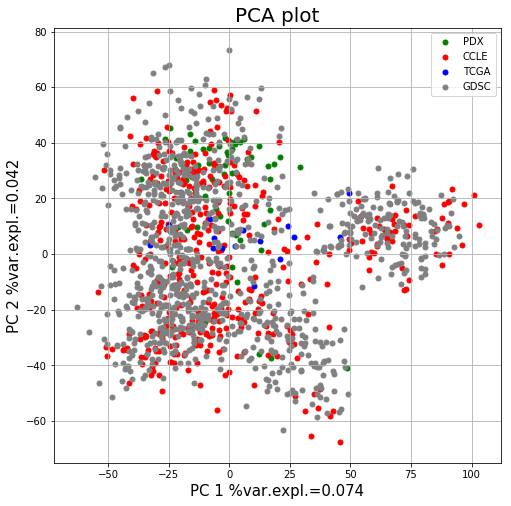

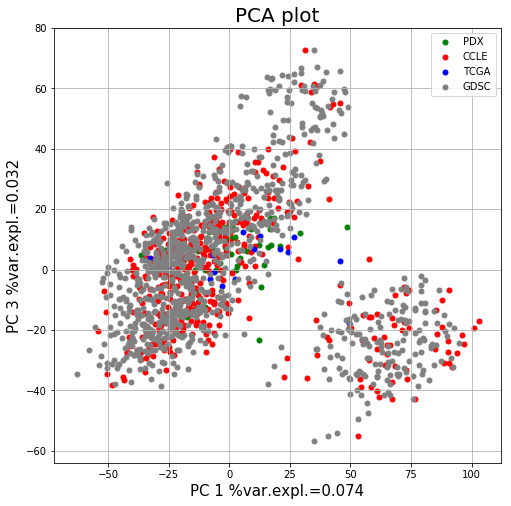

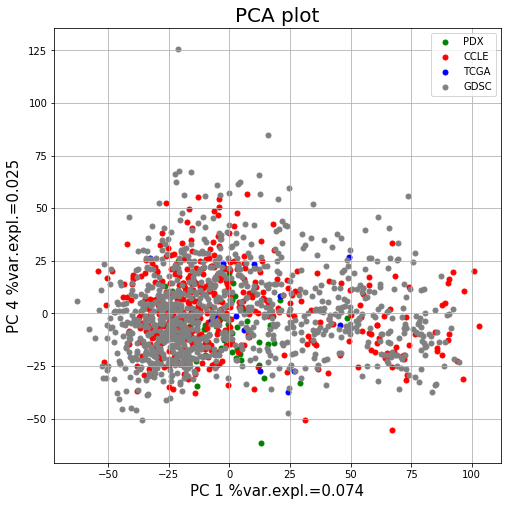

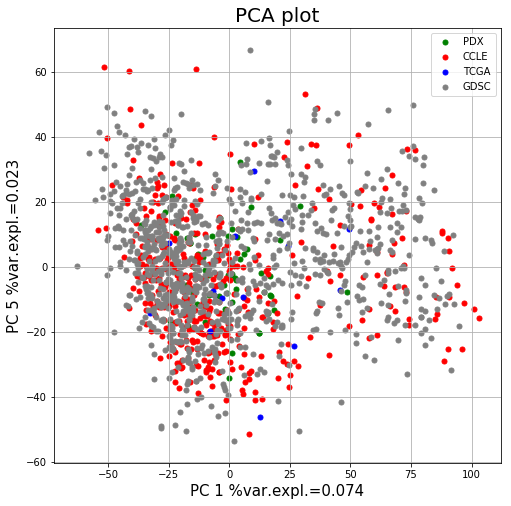

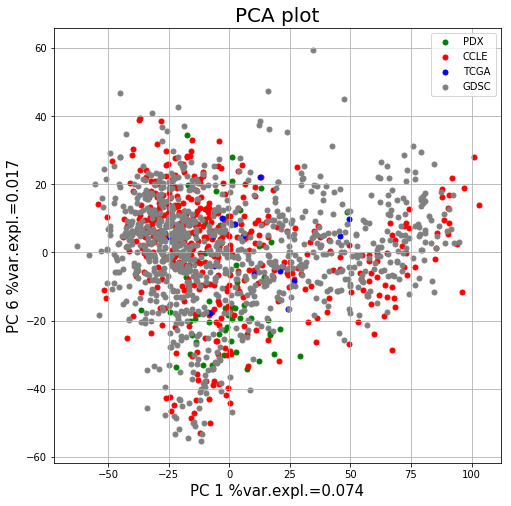

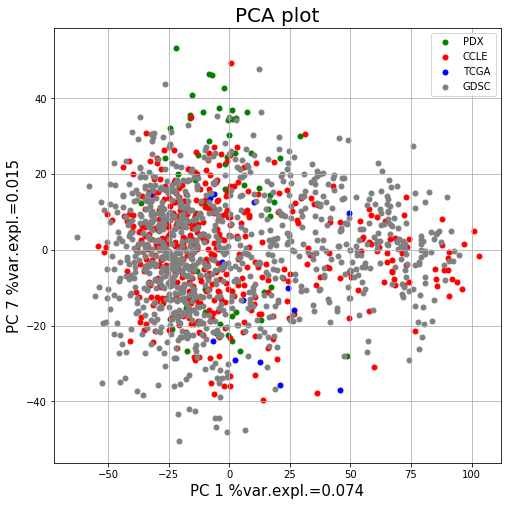

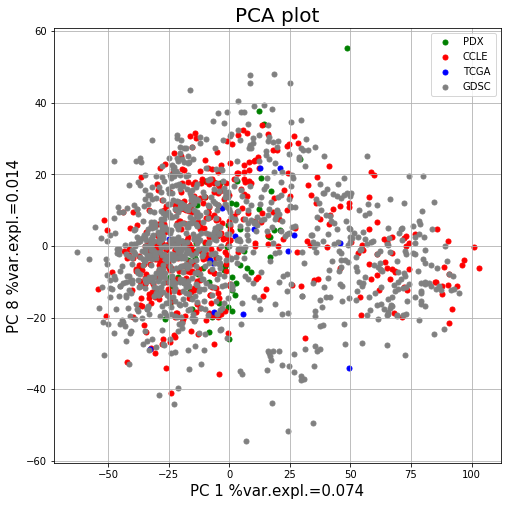

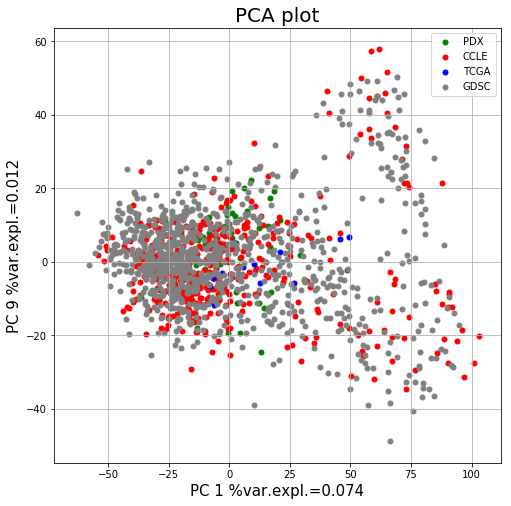

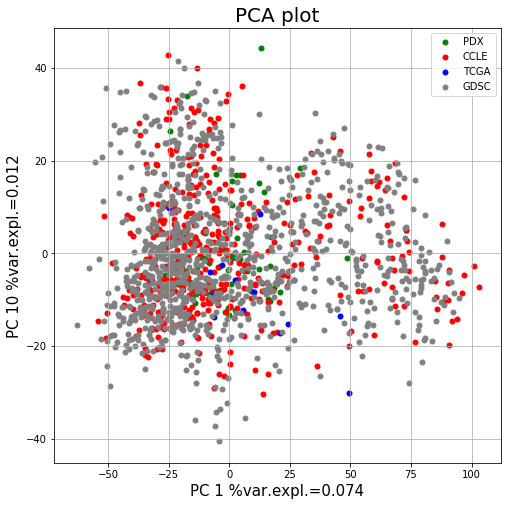

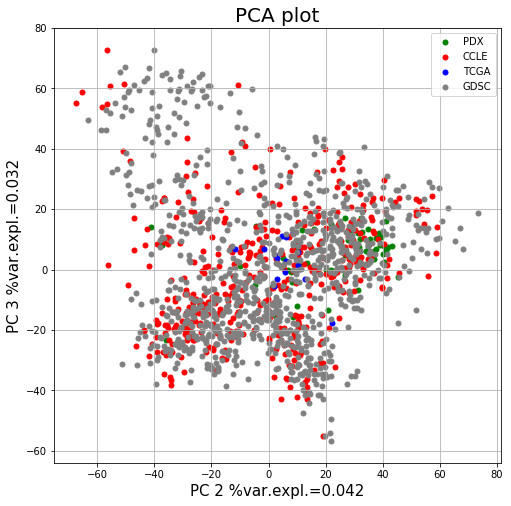

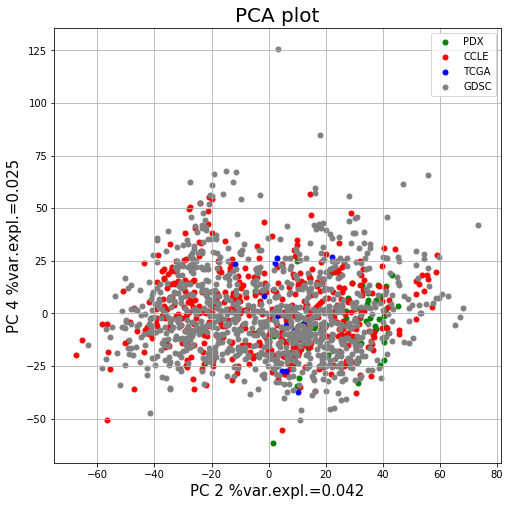

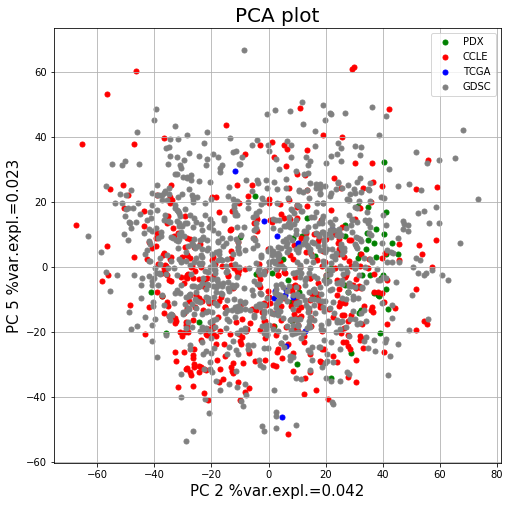

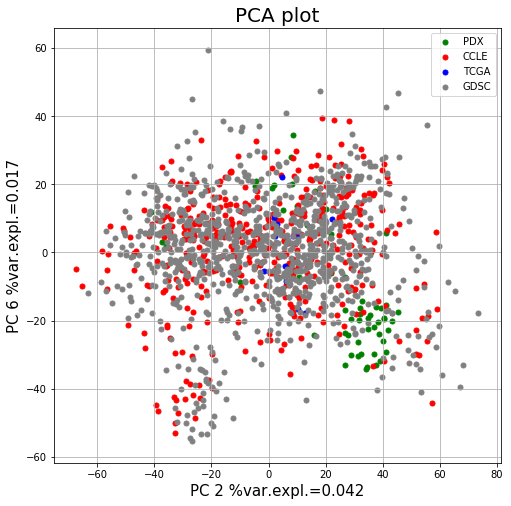

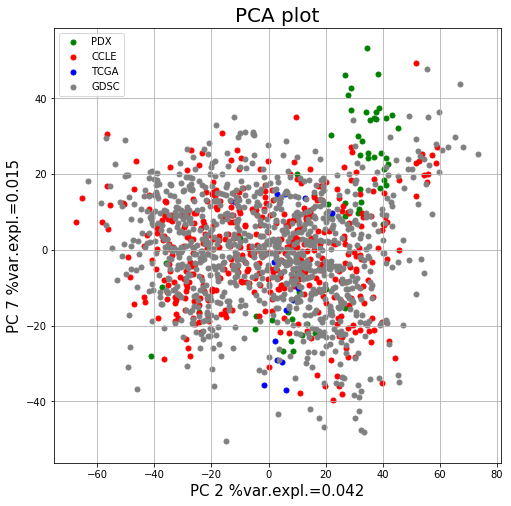

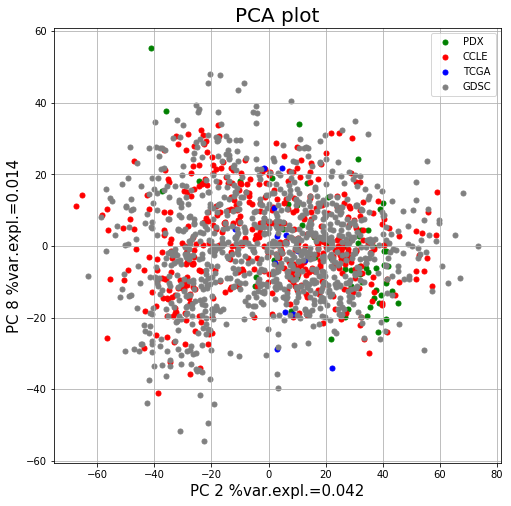

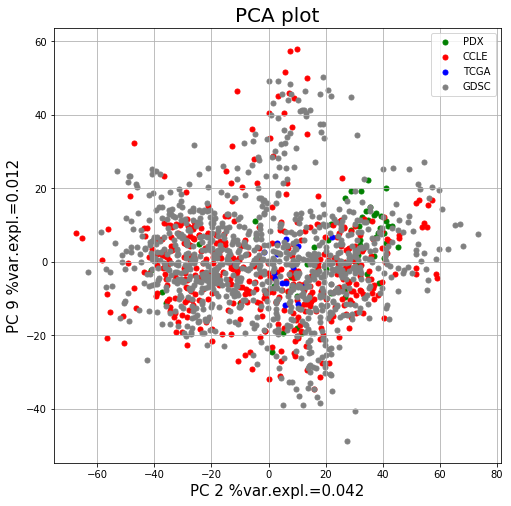

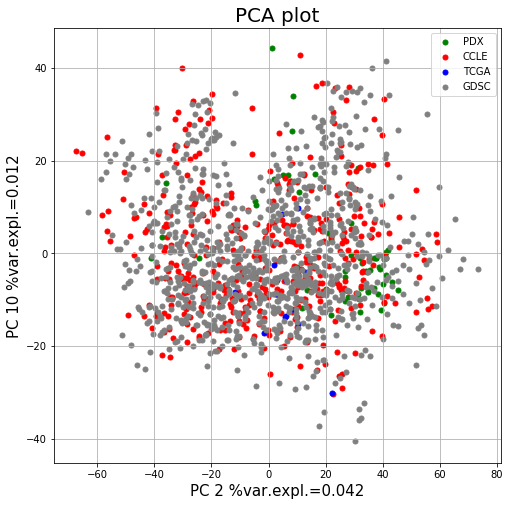

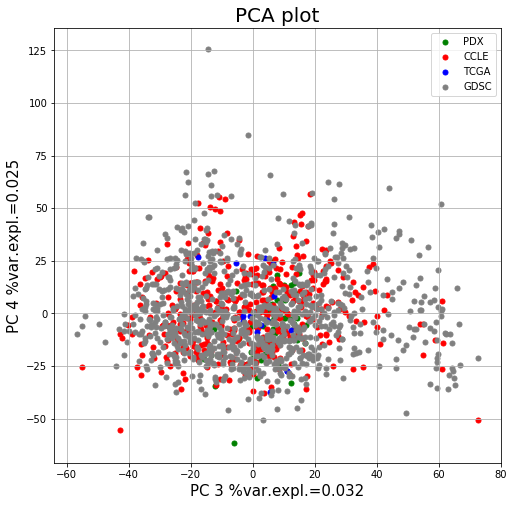

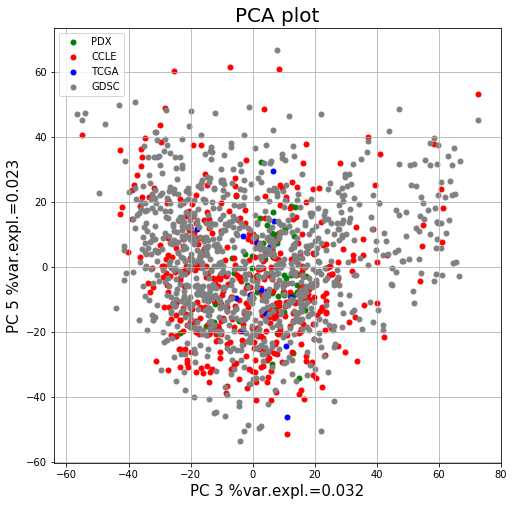

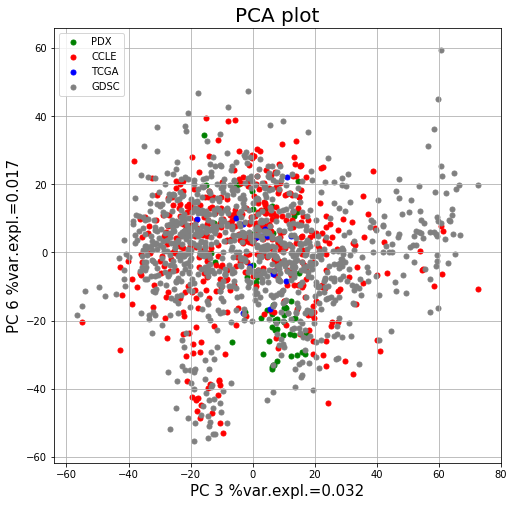

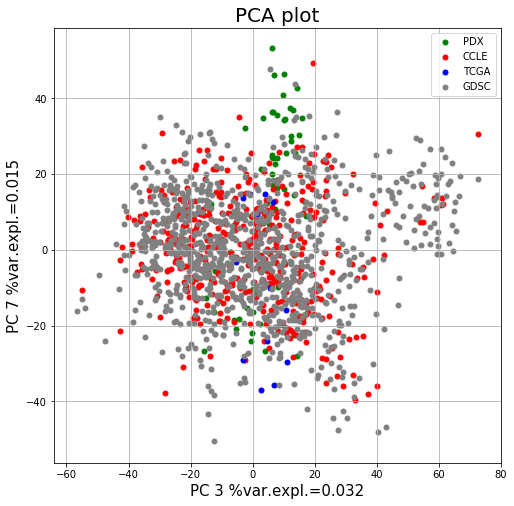

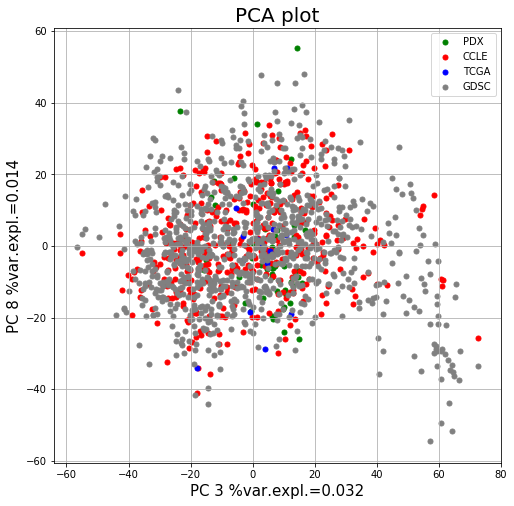

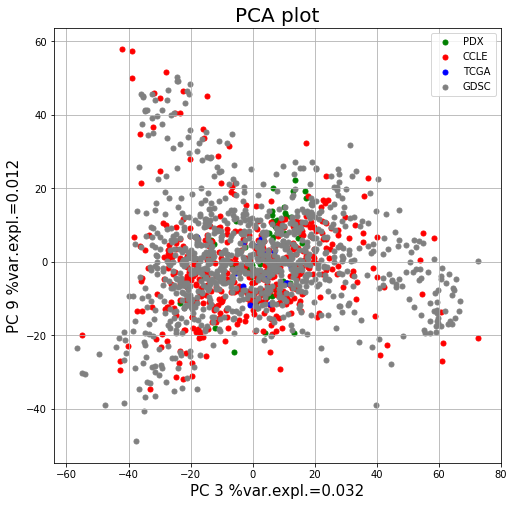

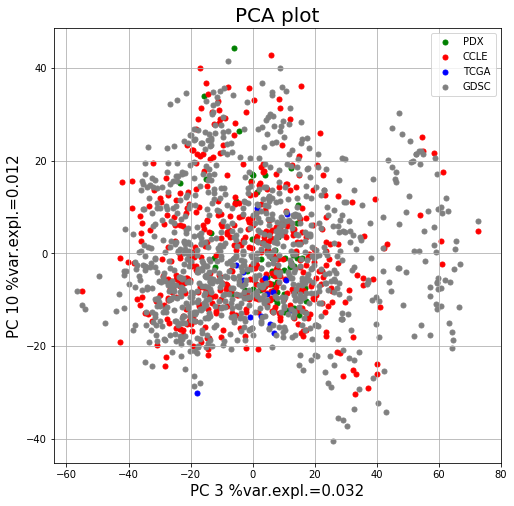

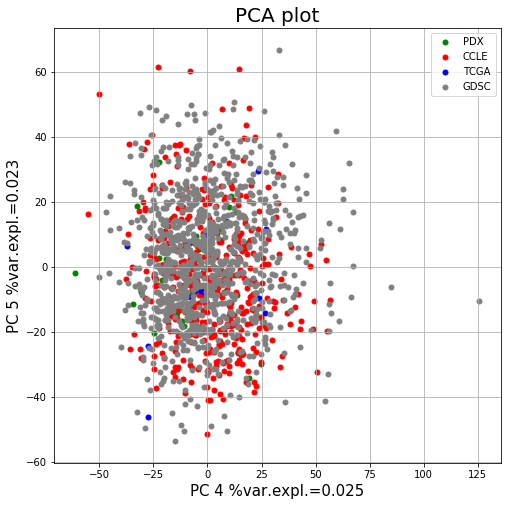

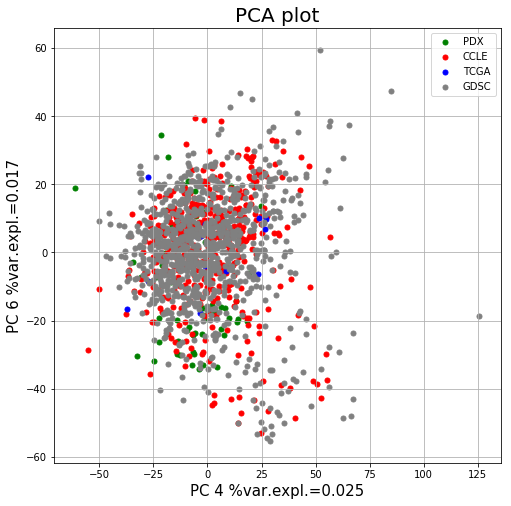

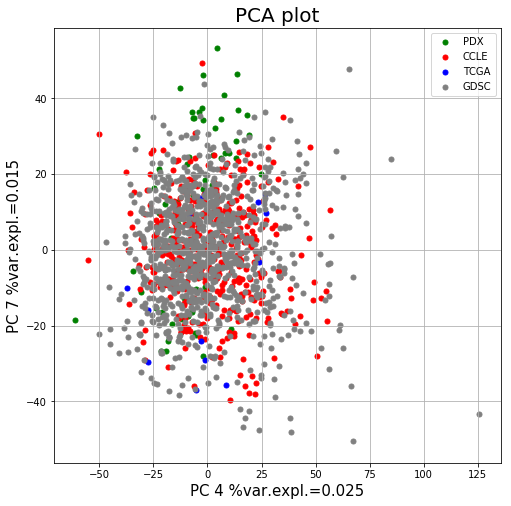

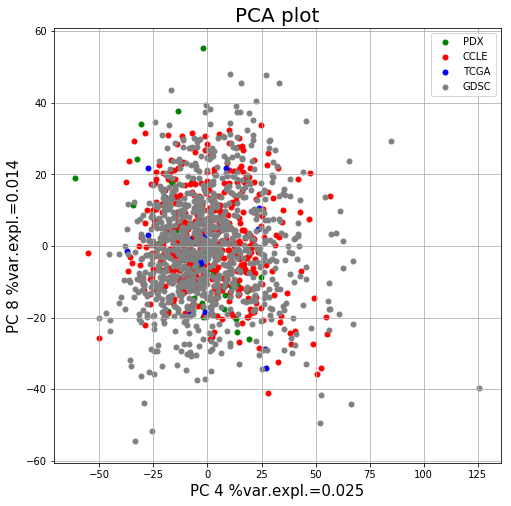

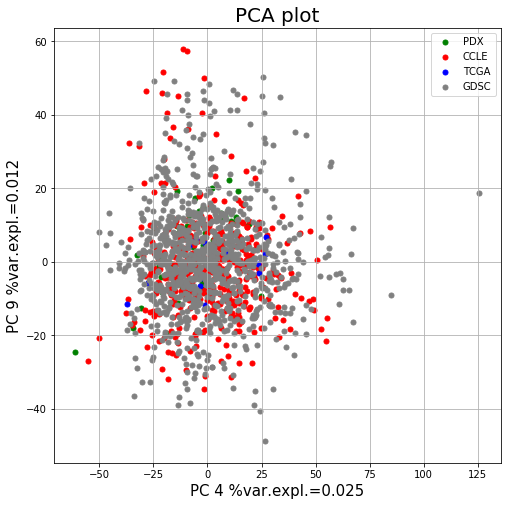

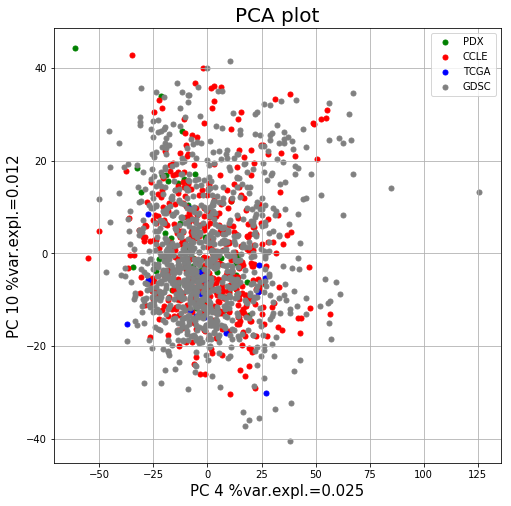

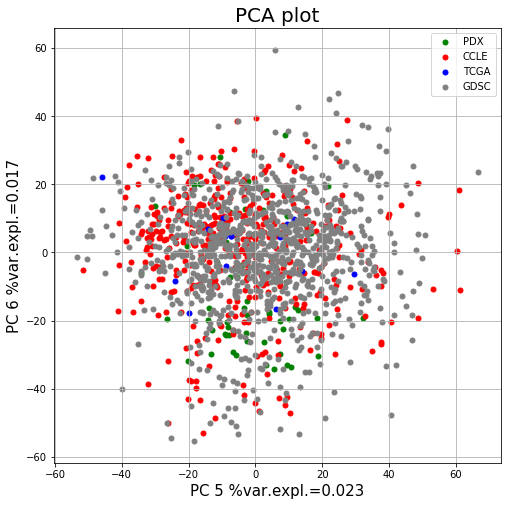

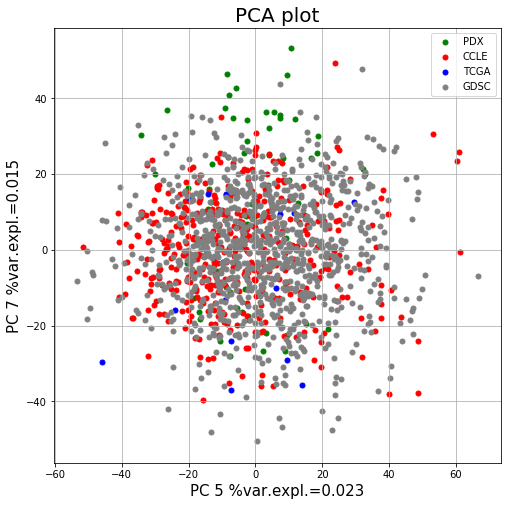

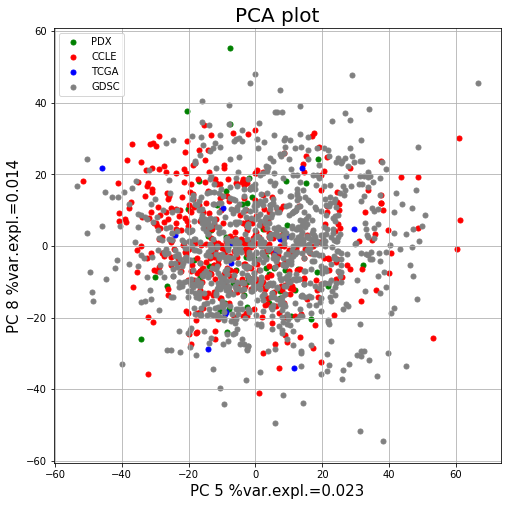

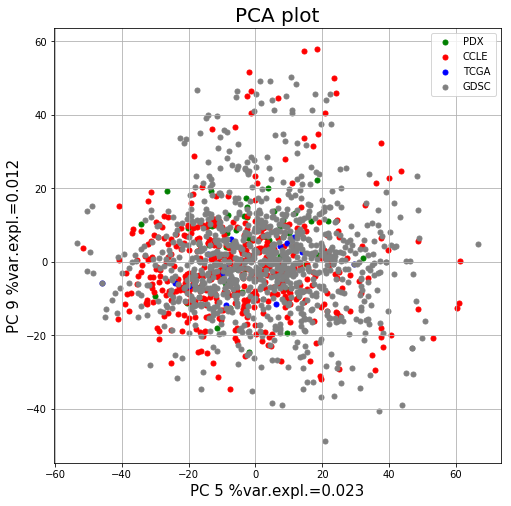

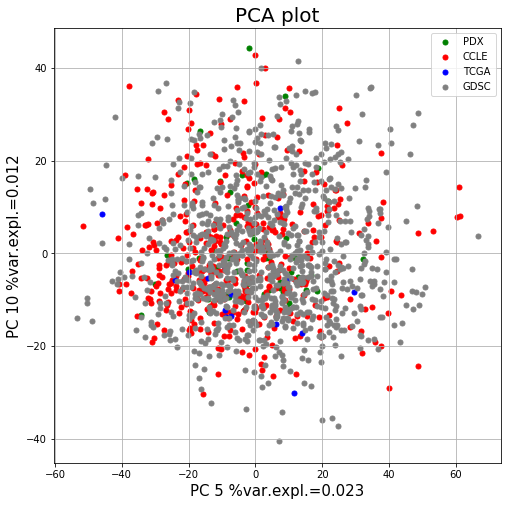

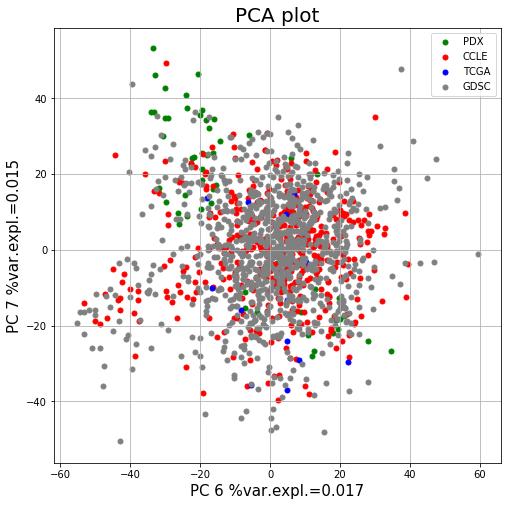

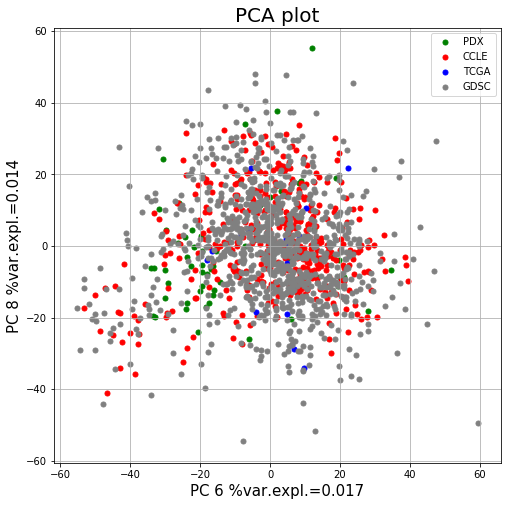

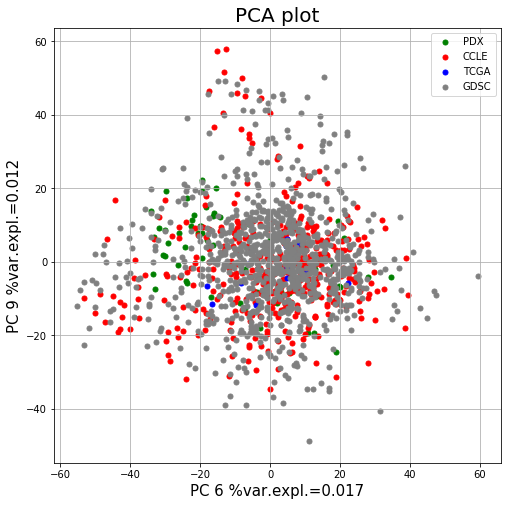

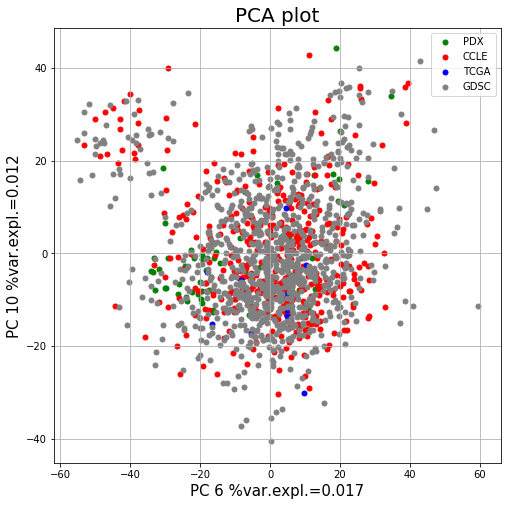

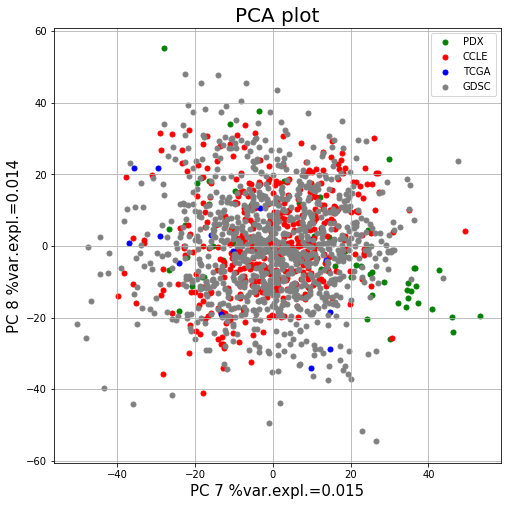

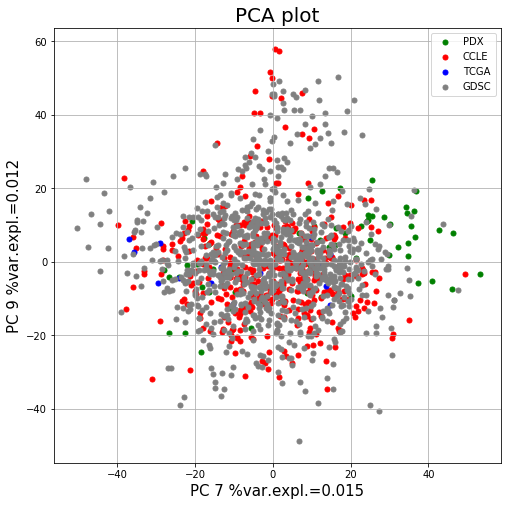

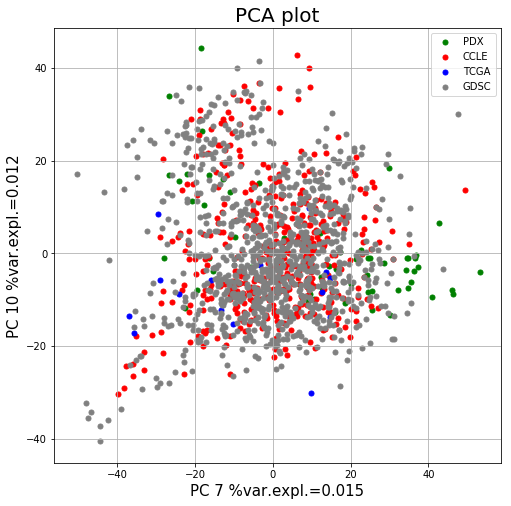

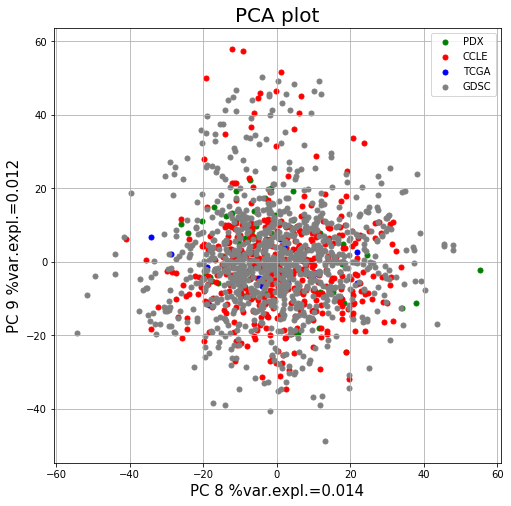

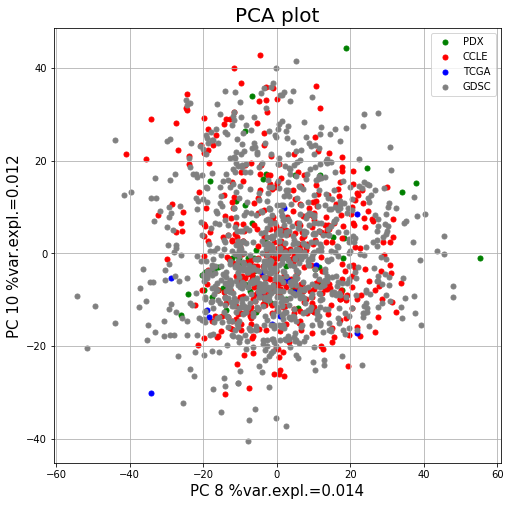

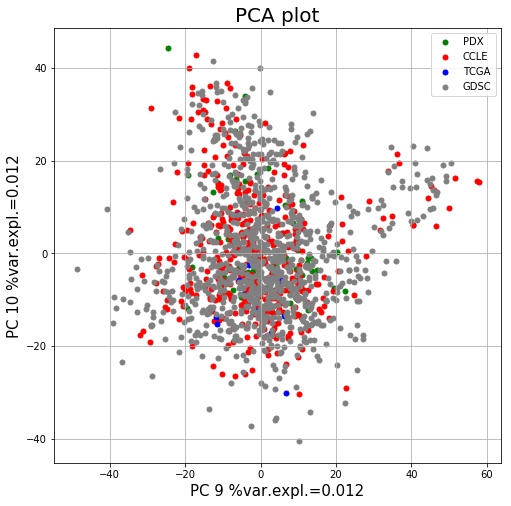

In [24]:
def plot_PCA(in_df,anno,n_components=2):
    pca = PCA(n_components=n_components).fit(in_df)
    pc = pca.transform(in_df)
    #print(pc.shape, anno.T.shape,in_df.shape)
    df = pd.DataFrame(data = pc , columns = ["PC "+str(x) for x in range(1,n_components+1)], index =in_df.index.values )
    df = pd.concat([df,anno.T],axis = 1)
    var_explained = pca.explained_variance_ratio_
    print(var_explained, sum(var_explained))
    #tmp = plt.hist(var_explained)
    
    colors = {"GDSC":"grey","CCLE":"red","TCGA":"blue","PDX":"green"}
    #markers  = {"Cetuximab":"*", "Erlotinib":"o", "Lapatinib":".", "Gefitinib":".", "Afatinib":".","ZD-6474":"."}
    for pc_i,pc_j in combinations(range(1,n_components+1),r=2):
        # plot 
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1) 
        ax.set_xlabel('PC '+str(pc_i)+" %var.expl.="+str(round(var_explained[pc_i-1],3)), fontsize = 15)
        ax.set_ylabel('PC '+str(pc_j)+" %var.expl.="+str(round(var_explained[pc_j-1],3)), fontsize = 15)
        ax.set_title('PCA plot', fontsize = 20)
        for cohort in colors.keys():
            indicesToKeep = df['cohort'] == cohort 
            ax.scatter(df.loc[indicesToKeep, 'PC '+str(pc_i)]
                       , df.loc[indicesToKeep, 'PC '+str(pc_j)]
                       , c = colors[cohort]
                       , s = 100 , marker = ".")
        ax.legend(colors.keys())
        ax.grid()
        plt.show()
    #return df
df_pca = plot_PCA(exprs_z.T,anno,n_components=10)

# make EGFRi- treated testing and training cohorts
### Trainig: GDSC


In [7]:
EGFRi_train_dict = {"GDSC":["Cetuximab", "Erlotinib", "Lapatinib", "Gefitinib", "Afatinib"]}

exprs_z = []
exprs = []
cnas = []
mutations = []
responses = []

for cohort in EGFRi_train_dict.keys():
    for drug in EGFRi_train_dict[cohort]:
        r = pd.read_csv(root_dir + "response/"+cohort+"_response."+drug+".tsv",sep = "\t", index_col = 0)
        r.rename(str,axis="index",inplace=True)
        snames= r.index.values
        responses.append(r)
        e = pd.read_csv(root_dir + "exprs/"+cohort+"_exprs."+drug+".tsv", sep = "\t", index_col = 0)
        e.rename(str,axis="columns",inplace=True)
        e = e[snames]
        exprs.append(e) 
        e_z = pd.read_csv(root_dir+"exprs/"+cohort+"_exprs.z."+drug+".tsv", sep = "\t", index_col = 0)
        e_z.rename(str,axis="columns",inplace=True)
        e_z = e_z[snames]
        exprs_z.append(e_z)
        snames = e_z.columns.values
        cna = pd.read_csv(root_dir + "CNA/"+cohort+"_CNA."+drug+".tsv",sep = "\t", index_col = 0)
        cna.rename(str,axis="columns",inplace=True)
        cna = cna[snames]
        cnas.append(cna)
        muts = pd.read_csv(root_dir + "mutations/"+cohort+"_mutations."+drug+".tsv",sep = "\t", index_col = 0)
        muts.rename(str,axis="columns",inplace=True)
        muts = muts[snames]
        mutations.append(muts)
        print(cohort,drug, len(snames))

order  = [exprs, exprs_z, cnas, mutations]
for i in range(0,4):
    order[i] = pd.concat(order[i],axis =1)
    order[i] = order[i].loc[:,~order[i].columns.duplicated()]
    order[i] = order[i].dropna()
    print("genes x samples", order[i].shape)

[exprs, exprs_z, cnas, mutations] = order
print(exprs.shape, exprs_z.shape, cnas.shape, mutations.shape)
exprs.to_csv(root_dir+"/exprs/" +"GDSC_exprs."+"EGFRi"+".tsv", sep = "\t")
exprs_z.to_csv(root_dir+"/exprs/" +"GDSC_exprs.z."+"EGFRi"+".tsv", sep = "\t")
cnas.to_csv(root_dir+"/CNA/" +"GDSC_CNA."+"EGFRi"+".tsv", sep = "\t")
mutations.to_csv(root_dir+"/mutations/" +"GDSC_mutations."+"EGFRi"+".tsv", sep = "\t")

GDSC Cetuximab 856
GDSC Erlotinib 362
GDSC Lapatinib 387
GDSC Gefitinib 825
GDSC Afatinib 828
genes x samples (18645, 940)
genes x samples (18645, 940)
genes x samples (24452, 940)
genes x samples (18421, 940)
(18645, 940) (18645, 940) (24452, 940) (18421, 940)


In [8]:
responses = pd.concat(responses,axis=0).loc[exprs.columns.values,:]
responses.drop_duplicates(inplace=True)
responses.to_csv(root_dir+"/response/"+"GDSC_response."+"EGFRi"+".tsv", sep = "\t")
responses.head(10)

response   logIC50       drug  exprs  CNA  mutations
sample_name                                                     
683665             R  6.294447  Cetuximab      1    1          1
683665             R  2.436586  Erlotinib      1    1          1
683665             R  2.684181  Lapatinib      1    1          1
683665             R  1.464855  Gefitinib      1    1          1
683665             R  1.490015   Afatinib      1    1          1
684052             R  6.387324  Cetuximab      1    1          1
684055             S  4.952125  Cetuximab      1    1          1
684055             R  3.342826  Erlotinib      1    1          1
684055             R  3.226492  Lapatinib      1    1          1
684057             R  6.393561  Cetuximab      1    1          1

In [9]:
responses.shape

(3258, 6)

### Testing: PDX, TCGA, 
    * CCLE has no binary resonse 

In [10]:
EGFRi_test_dict = {"TCGA":["Cetuximab","Erlotinib","Gefitinib"],
"PDX":["Cetuximab","Erlotinib"],"CCLE": ["Erlotinib", "Lapatinib", "ZD-6474"]}

In [11]:
for cohort in EGFRi_test_dict.keys():
    exprs_z = []
    exprs = []
    cnas = []
    mutations = []
    responses = []
    for drug in EGFRi_test_dict[cohort]:
        r = pd.read_csv(root_dir + "response/"+cohort+"_response."+drug+".tsv",sep = "\t", index_col = 0)
        r.rename(str,axis="index",inplace=True)
        snames= r.index.values
        responses.append(r)
        e = pd.read_csv(root_dir + "exprs/"+cohort+"_exprs."+drug+".tsv", sep = "\t", index_col = 0)
        e.rename(str,axis="columns",inplace=True)
        e = e[snames]
        exprs.append(e) 
        e_z = pd.read_csv(root_dir+"exprs/"+cohort+"_exprs.z."+drug+".tsv", sep = "\t", index_col = 0)
        e_z.rename(str,axis="columns",inplace=True)
        e_z = e_z[snames]
        exprs_z.append(e_z)
        snames = e_z.columns.values
        cna = pd.read_csv(root_dir + "CNA/"+cohort+"_CNA."+drug+".tsv",sep = "\t", index_col = 0)
        cna.rename(str,axis="columns",inplace=True)
        cna = cna[snames]
        cnas.append(cna)
        muts = pd.read_csv(root_dir + "mutations/"+cohort+"_mutations."+drug+".tsv",sep = "\t", index_col = 0)
        muts.rename(str,axis="columns",inplace=True)
        muts = muts[snames]
        mutations.append(muts)
    
    print(cohort)
    order  = [exprs, exprs_z, cnas, mutations]
    for i in range(0,4):
        order[i] = pd.concat(order[i],axis =1)
        order[i] = order[i].loc[:,~order[i].columns.duplicated()]
        order[i] = order[i].dropna()
        print("genes x samples", order[i].shape)

    [exprs, exprs_z, cnas, mutations] = order
    
    exprs.to_csv(root_dir+"/exprs/" +cohort+"_exprs."+"EGFRi"+".tsv", sep = "\t")
    exprs_z.to_csv(root_dir+"/exprs/" +cohort+"_exprs.z."+"EGFRi"+".tsv", sep = "\t")
    cnas.to_csv(root_dir+"/CNA/" +cohort+"_CNA."+"EGFRi"+".tsv", sep = "\t")
    mutations.to_csv(root_dir+"/mutations/" +cohort+"_mutations."+"EGFRi"+".tsv", sep = "\t")
    
    responses = pd.concat(responses,axis=0).loc[exprs.columns.values,:]
    responses.drop_duplicates(inplace=True)
    responses.to_csv(root_dir+"/response/"+cohort+"_response."+"EGFRi"+".tsv", sep = "\t")
    #responses.head(10)

TCGA
genes x samples (20531, 15)
genes x samples (20191, 15)
genes x samples (36019, 15)
genes x samples (15050, 15)
CCLE
genes x samples (20342, 436)
genes x samples (20342, 436)
genes x samples (35972, 436)
genes x samples (1643, 436)
PDX
genes x samples (22443, 61)
genes x samples (21060, 61)
genes x samples (23271, 61)
genes x samples (15061, 61)


In [12]:
responses

drug response ResponseCategory  Treatment Treatment target  \
sample_name                                                                    
X-1027       Cetuximab        R               PD  cetuximab             EGFR   
X-1119       Cetuximab        R               PD  cetuximab             EGFR   
X-1156       Cetuximab        R               PD  cetuximab             EGFR   
X-1156       Erlotinib        R               PD  erlotinib             EGFR   
X-1167       Cetuximab        R               PD  cetuximab             EGFR   
X-1172       Cetuximab        R               PD  cetuximab             EGFR   
X-1172       Erlotinib        R               PD  erlotinib             EGFR   
X-1173       Cetuximab        R               PD  cetuximab             EGFR   
X-1270       Cetuximab        R               PD  cetuximab             EGFR   
X-1290       Cetuximab        R               SD  cetuximab             EGFR   
X-1303       Cetuximab        S               PR  cetuximab             EGFR   
X-1323       Cetuximab        R               PD  cetuximab             EGFR   
X-1323       Erlotinib        R               PD  erlotinib             EGFR   
X-1329       Cetuximab        R               PD  cetuximab             EGFR   
X-1442       Cetuximab        R               PD  cetuximab             EGFR   
X-1442       Erlotinib        R               SD  erlotinib             EGFR   
X-1443       Cetuximab        S               CR  cetuximab             EGFR   
X-1479       Cetuximab        R               SD  cetuximab             EGFR   
X-1499       Cetuximab        R               PD  cetuximab             EGFR   
X-1499       Erlotinib        R               PD  erlotinib             EGFR   
X-1500       Cetuximab        S               PR  cetuximab             EGFR   
X-1536       Cetuximab        R               PD  cetuximab             EGFR   
X-1538       Cetuximab        R               PD  cetuximab             EGFR   
X-1586       Cetuximab        R               PD  cetuximab             EGFR   
X-1586       Erlotinib        R               SD  erlotinib             EGFR   
X-1658       Cetuximab        R               PD  cetuximab             EGFR   
X-1658       Erlotinib        S               PR  erlotinib             EGFR   
X-1725       Cetuximab        R               PD  cetuximab             EGFR   
X-1725       Erlotinib        R               SD  erlotinib             EGFR   
X-1787       Cetuximab        R               PD  cetuximab             EGFR   
...                ...      ...              ...        ...              ...   
X-2239       Cetuximab        R               PD  cetuximab             EGFR   
X-2403       Cetuximab        R               PD  cetuximab             EGFR   
X-2483       Cetuximab        R               PD  cetuximab             EGFR   
X-2484       Cetuximab        R               PD  cetuximab             EGFR   
X-2538       Cetuximab        R               PD  cetuximab             EGFR   
X-2573       Cetuximab        R               SD  cetuximab             EGFR   
X-2659       Cetuximab        R               PD  cetuximab             EGFR   
X-2822       Cetuximab        R               PD  cetuximab             EGFR   
X-2846       Cetuximab        R               SD  cetuximab             EGFR   
X-2861       Cetuximab        R               PD  cetuximab             EGFR   
X-3029       Cetuximab        S               PR  cetuximab             EGFR   
X-3029       Erlotinib        S               PR  erlotinib             EGFR   
X-3093       Cetuximab        R               PD  cetuximab             EGFR   
X-3205       Cetuximab        R               PD  cetuximab             EGFR   
X-3224       Cetuximab        R               PD  cetuximab             EGFR   
X-3237       Cetuximab        R               PD  cetuximab             EGFR   
X-3237       Erlotinib        R               PD  erlotinib             EGFR   
X-3671       Cetux

In [13]:
#root_dir = "" # set path to the data folder
# reading EGFRi training cohort 
responses = pd.read_csv(root_dir+"/response/"+"GDSC_response."+"EGFRi"+".tsv", sep = "\t")
drugs = set(responses["drug"].values)
exprs_z = pd.read_csv(root_dir+"/exprs/" +"GDSC_exprs.z."+"EGFRi"+".tsv", sep="\t", index_col=0) # z-score transformed expressions
cna = pd.read_csv(root_dir+"/CNA/" +"GDSC_CNA."+"EGFRi"+".tsv", sep = "\t", index_col=0) # CNA 
mut = pd.read_csv(root_dir+"/mutations/" +"GDSC_mutations."+"EGFRi"+".tsv", sep="\t", index_col=0) # mutations 
expression_zscores = []
CNA=[]
mutations = []
for drug in drugs:
    samples = map(str, responses.loc[responses["drug"]==drug,"sample_name"].values)
    e_z = exprs_z.loc[:,samples]
    c = cna.loc[:,samples]
    m = mut.loc[:,samples]
    # next 3 rows if you want non-unique sample names
    e_z.rename(lambda x : str(x)+"_"+drug, axis = "columns", inplace=True)
    c.rename(lambda x : str(x)+"_"+drug, axis = "columns", inplace=True)
    m.rename(lambda x : str(x)+"_"+drug, axis = "columns", inplace=True)
    expression_zscores.append(e_z)
    CNA.append(c)
    mutations.append(m)
    print(drug, len(samples), e_z.shape, c.shape, m.shape)

expression_zscores = pd.concat(expression_zscores, axis =1 )
CNA = pd.concat(CNA, axis =1 )
mutations = pd.concat(mutations, axis =1 )

print("response",responses.shape,
      "expression", expression_zscores.shape,
      "CNA", CNA.shape,
      "mutations", mutations.shape)

Lapatinib 387 (18645, 387) (24452, 387) (18421, 387)
Gefitinib 825 (18645, 825) (24452, 825) (18421, 825)
Cetuximab 856 (18645, 856) (24452, 856) (18421, 856)
Afatinib 828 (18645, 828) (24452, 828) (18421, 828)
Erlotinib 362 (18645, 362) (24452, 362) (18421, 362)
response (3258, 7) expression (18645, 3258) CNA (24452, 3258) mutations (18421, 3258)


683665_Erlotinib  684055_Erlotinib  684057_Erlotinib  \
ENTREZID                                                          
1                 -0.471156          1.356514          0.651000   
2                 -0.185752         -0.277542          1.657888   
9                  0.970241          0.088709         -0.497711   
10                -0.408128         -0.275483         -0.121217   
12                -0.416151         -0.515386         -0.398455   
13                -0.438416         -0.624871         -0.280490   
14                -1.154692          0.124341          0.645590   
15                 0.526213         -1.269967          0.215833   
16                -0.795092          2.078836         -0.172360   
18                -0.633744          2.519799         -0.217087   
19                -0.782891          0.258216         -0.757068   
20                -0.158815         -1.130895          0.032805   
21                -0.871629         -0.232487          0.626463   
22                 1.080421         -1.995198          0.831292   
23                 0.509494          0.436414          0.917848   
24                 0.789324          0.253259         -0.650154   
25                -1.057123          1.075647          0.276122   
26                 0.123009         -0.298338         -0.378392   
27                -1.150800          0.266098          0.793151   
28                 0.069739         -0.066644          0.766977   
29                 0.380773          2.173963          2.052899   
30                 0.461737          0.445543         -0.091501   
31                -2.180003         -0.955526          1.225213   
32                -1.061376          2.513140          0.577716   
33                -0.504813         -0.002763          0.451054   
34                 2.049503         -0.707149         -0.786987   
35                -0.991168         -1.310365         -1.031503   
36                 1.428510          0.243718         -0.928736   
37                -0.047698         -0.030426          0.414023   
38                -0.396570         -0.137279         -0.503430   
...                     ...               ...               ...   
105376874         -1.070931         -0.321317          0.443675   
105377021          0.002406         -0.361926          0.196043   
105377245         -0.251450         -0.941258          0.700184   
105377283         -0.545523         -0.321369         -0.028840   
105377603         -0.858269         -0.424167          0.789060   
105377918          0.110690         -0.253124         -0.520890   
105378099         -1.250614          0.752484          0.376894   
105378305          1.324951         -0.734415          0.252921   
105378373          0.257670         -1.569539         -1.022795   
105378532          1.250220         -0.583819         -0.926140   
105378825          3.471881          1.233766          0.964697   
105379283         -0.154650          0.389135         -0.680605   
106478910         -0.466797         -0.041416          1.832163   
107984121         -0.701696          0.984384         -0.748561   
107984125          1.059397          0.174598          0.405841   
107984199          1.283535         -0.557103         -0.024863   
107984208         -0.336727         -1.724091          0.407344   
107984276         -0.194348         -1.442255         -0.933034   
107984325         -0.003976         -0.374908         -0.444036   
107984411          0.737873         -0.001606          0.863035   
107984648          0.975761         -0.378854          1.448617   
107984889          0.149442         -1.350209         -1.477721   
107984944         -0.427116          2.330512          0.665078   
107984989          2.062294          0.694979          0.522040   
107985476          0.297611          0.633864         -1.230154   
107985932         -0.300797         -0.332528         -0.045932   
107986153          0.489673         -1.426776         -1.0

# Statistics 

In [5]:
root_dir

'/home/olya/SFU/Hossein/v2/'

In [6]:
def dataset_exprs_stats(row,root_dir=root_dir):
    drug = row["drug"]
    test = row["testing set"]
    train = row["training set"]

    # read responses
    test_r_fname = root_dir+"/response/" + test+"_response."+drug+".tsv"
    test_r = pd.read_csv(test_r_fname, sep = "\t",index_col=0)
    test_r_R = set(test_r.loc[test_r["response"]=="R", :].index.values)
    test_r_S = set(test_r.loc[test_r["response"]=="S", :].index.values)
    train_r_fname = root_dir+"/response/" + train+"_response."+drug+".tsv"
    train_r = pd.read_csv(train_r_fname, sep = "\t",index_col=0)
    train_r_R = map(str,set(train_r.loc[train_r["response"]=="R", :].index.values))
    train_r_S = map(str,set(train_r.loc[train_r["response"]=="S", :].index.values))

    # read expression GDSC_exprs.z.Cisplatin.eb_with.GSE18864_exprs.z.Cisplatin.tsv
    test_e_fname = root_dir+"/exprs_homogenized/"+test+"_exprs.z."+drug+".eb_with."+train+"_exprs.z."+drug+".tsv"
    test_e = pd.read_csv(test_e_fname, sep = "\t",index_col=0)
    train_e_fname = root_dir+"/exprs_homogenized/"+train+"_exprs.z."+drug+".eb_with."+test+"_exprs.z."+drug+".tsv"
    train_e = pd.read_csv(train_e_fname, sep = "\t",index_col=0)

    shared_genes = len(set(test_e.index.values).intersection(set(train_e.index.values)))
    # samples with expression and response
    test_r_R = test_e.loc[:,test_r_R ].shape[1]
    test_r_S = test_e.loc[:,test_r_S ].shape[1]
    test_n_samples = str(test_r_R+test_r_S)+" (R:"+str(test_r_R)+", S:"+str(test_r_S)+')'

    train_r_R = train_e.loc[:,train_r_R ].shape[1]
    train_r_S = train_e.loc[:,train_r_S ].shape[1]
    train_n_samples = str(train_r_R+train_r_S)+" (R:"+str(train_r_R)+", S:"+str(train_r_S)+')'

    return pd.Series({"train_exprs_file":train_e_fname.replace(root_dir+"/",""), 
                      "test_exprs_file":test_e_fname.replace(root_dir+"/",""),
                      "train_response_file":train_r_fname.replace(root_dir+"/",""), 
                      "test_response_file":test_r_fname.replace(root_dir+"/",""),
                      "train_n_samples":train_n_samples, "test_n_samples":test_n_samples,
                     "shared_genes":shared_genes})

In [7]:
exprs = pd.read_csv(root_dir+"cohorts.tsv", sep = "\t")
exprs = exprs.loc[exprs["type"]=="Expression",:]
exprs_stats = exprs.apply(lambda  row : dataset_exprs_stats(row,root_dir=root_dir),axis=1)
exprs_stats = exprs_stats[["test_n_samples","train_n_samples","shared_genes","test_exprs_file","train_exprs_file","train_response_file","test_response_file"]]
exprs_stats = pd.concat([exprs, exprs_stats],axis = 1)
exprs_stats.to_csv(root_dir+ "Expression_only.cohorts.tsv", sep = "\t")
exprs_stats

drug        type training set    testing set    test_n_samples  \
0   Docetaxel  Expression         GDSC        GSE6434   24 (R:14, S:10)   
1   Docetaxel  Expression         GDSC       GSE25065    51 (R:5, S:46)   
2  Paclitaxel  Expression         GDSC       GSE25065   84 (R:26, S:58)   
3   Cisplatin  Expression         GDSC       GSE18864    24 (R:8, S:16)   
4   Erlotinib  Expression         GDSC       GSE33072   25 (R:12, S:13)   
5  Bortezomib  Expression         GDSC  GSE9782-GPL96  169 (R:84, S:85)   
6  Bortezomib  Expression         GDSC  GSE9782-GPL97  169 (R:84, S:85)   

     train_n_samples  shared_genes  \
0  829 (R:764, S:65)          8257   
1  829 (R:764, S:65)         11820   
2  389 (R:363, S:26)         11820   
3  829 (R:752, S:77)         17088   
4  362 (R:298, S:64)         18064   
5  391 (R:360, S:31)         11636   
6  391 (R:360, S:31)          7752   

                                     test_exprs_file  \
0  exprs_homogenized/GSE6434_exprs.z.Docetaxel.eb...   
1  exprs_homogenized/GSE25065_exprs.z.Docetaxel.e...   
2  exprs_homogenized/GSE25065_exprs.z.Paclitaxel....   
3  exprs_homogenized/GSE18864_exprs.z.Cisplatin.e...   
4  exprs_homogenized/GSE33072_exprs.z.Erlotinib.e...   
5  exprs_homogenized/GSE9782-GPL96_exprs.z.Bortez...   
6  exprs_homogenized/GSE9782-GPL97_exprs.z.Bortez...   

                                    train_exprs_file  \
0  exprs_homogenized/GDSC_exprs.z.Docetaxel.eb_wi...   
1  exprs_homogenized/GDSC_exprs.z.Docetaxel.eb_wi...   
2  exprs_homogenized/GDSC_exprs.z.Paclitaxel.eb_w...   
3  exprs_homogenized/GDSC_exprs.z.Cisplatin.eb_wi...   
4  exprs_homogenized/GDSC_exprs.z.Erlotinib.eb_wi...   
5  exprs_homogenized/GDSC_exprs.z.Bortezomib.eb_w...   
6  exprs_homogenized/GDSC_exprs.z.Bortezomib.eb_w...   

                     train_response_file  \
0   response/GDSC_response.Docetaxel.tsv   
1   response/GDSC_response.Docetaxel.tsv   
2  response/GDSC_response.Paclitaxel.tsv   
3   response/GDSC_response.Cisplatin.tsv   
4   response/GDSC_response.Erlotinib.tsv   
5  response/GDSC_response.Bortezomib.tsv   
6  response/GDSC_response.Bortezomib.tsv   

                               test_response_file  
0         response/GSE6434_response.Docetaxel.tsv  
1        response/GSE25065_response.Docetaxel.tsv  
2       response/GSE25065_response.Paclitaxel.tsv  
3        response/GSE18864_response.Cisplatin.tsv  
4        response/GSE33072_response.Erlotinib.tsv  
5  response/GSE9782-GPL96_response.Bortezomib.tsv  
6  response/GSE9782-GPL97_response.Bortezomib.tsv

In [27]:
def dataset_omics_stats(row,root_dir=root_dir):
    drug = row["drug"]
    test = row["testing set"]
    train = row["training set"]
    
    # read responses
    test_r_fname = root_dir+"/response/" + test+"_response."+drug+".tsv"
    test_r = pd.read_csv(test_r_fname, sep = "\t",index_col=0)
    test_r_R = set(test_r.loc[test_r["response"]=="R", :].index.values)
    test_r_S = set(test_r.loc[test_r["response"]=="S", :].index.values)
    train_r_fname = root_dir+"/response/" + train+"_response."+drug+".tsv"
    train_r = pd.read_csv(train_r_fname, sep = "\t",index_col=0)
    train_r_R = map(str,set(train_r.loc[train_r["response"]=="R", :].index.values))
    train_r_S = map(str,set(train_r.loc[train_r["response"]=="S", :].index.values))
    
    # read expression 
    test_e_fname = root_dir+"/exprs_homogenized/"+test+"_exprs."+drug+".eb_with."+train+"_exprs."+drug+".tsv"
    test_e = pd.read_csv(test_e_fname, sep = "\t",index_col=0)
    train_e_fname = root_dir+"/exprs_homogenized/"+train+"_exprs."+drug+".eb_with."+test+"_exprs."+drug+".tsv"
    train_e = pd.read_csv(train_e_fname, sep = "\t",index_col=0)
    
    shared_e_genes = len(set(test_e.index.values).intersection(set(train_e.index.values)))
    # read CNA
    test_c_fname = root_dir+"/CNA/"+test+"_CNA."+drug+".tsv"
    test_c = pd.read_csv(test_c_fname, sep = "\t",index_col=0)
    train_c_fname = root_dir+"/CNA/"+train+"_CNA."+drug+".tsv"
    train_c = pd.read_csv(train_c_fname, sep = "\t",index_col=0)
    
    shared_c_genes = len(set(test_c.index.values).intersection(set(train_c.index.values)))
    # read mutations
    test_m_fname = root_dir+"/mutations/"+test+"_mutations."+drug+".tsv"
    test_m = pd.read_csv(test_m_fname, sep = "\t",index_col=0)
    train_m_fname = root_dir+"/mutations/"+train+"_mutations."+drug+".tsv"
    train_m = pd.read_csv(train_m_fname, sep = "\t",index_col=0)
    
    shared_m_genes = len(set(test_m.index.values).intersection(set(train_m.index.values)))
    shared_genes = str(shared_e_genes+shared_c_genes+shared_m_genes)+" (exprs:"+str(shared_e_genes)+", CNA:"+str(shared_c_genes)+", mut:"+str(shared_m_genes)+')'
    # samples with all OMIC and response
    test_r_R = set(test_r_R).intersection(set(test_e.columns.values)).intersection(set(test_c.columns.values)).intersection(set(test_m.columns.values))
    test_r_R = len(test_r_R)                                                                                                                 
    test_r_S = set(test_r_S).intersection(set(test_e.columns.values)).intersection(set(test_c.columns.values)).intersection(set(test_m.columns.values))
    test_r_S = len(test_r_S)  
    test_n_samples = str(test_r_R+test_r_S)+" (R:"+str(test_r_R)+", S:"+str(test_r_S)+')'
    
    train_r_R = set(train_r_R).intersection(set(train_e.columns.values)).intersection(set(train_c.columns.values)).intersection(set(train_m.columns.values))
    train_r_R = len(train_r_R) 
    train_r_S = set(train_r_S).intersection(set(train_e.columns.values)).intersection(set(train_c.columns.values)).intersection(set(train_m.columns.values))
    train_r_S = len(train_r_S)
    train_n_samples = str(train_r_R+train_r_S)+" (R:"+str(train_r_R)+", S:"+str(train_r_S)+')'
    
    return pd.Series({"train_exprs_file":train_e_fname.replace(root_dir+"/",""), 
                      "test_exprs_file":test_e_fname.replace(root_dir+"/",""),
                      "train_CNA_file":train_c_fname.replace(root_dir+"/",""), 
                      "test_CNA_file":test_c_fname.replace(root_dir+"/",""),
                      "train_mut_file":train_m_fname.replace(root_dir+"/",""), 
                      "test_mut_file":test_m_fname.replace(root_dir+"/",""),
                      "train_response_file":train_r_fname.replace(root_dir+"/",""), 
                      "test_response_file":test_r_fname.replace(root_dir+"/",""),
                      "train_n_samples":train_n_samples, "test_n_samples":test_n_samples,
                     "shared_genes":shared_genes})

In [22]:
multi_omics = pd.read_csv(root_dir+"cohorts.tsv", sep = "\t")
multi_omics = multi_omics.loc[multi_omics["type"]=="Multi-OMICs",:]
multi_omics_stats = multi_omics.apply(lambda  row : dataset_omics_stats(row,root_dir=root_dir),axis=1)
multi_omics_stats = multi_omics_stats[["test_n_samples","train_n_samples","shared_genes",
             "test_exprs_file","test_CNA_file","test_mut_file",
             "train_exprs_file","train_CNA_file","train_mut_file",
             "train_response_file","test_response_file"]]

multi_omics_stats = pd.concat([multi_omics, multi_omics_stats],axis = 1)
multi_omics_stats.to_csv(root_dir+ "Multi-OMICs.cohorts.tsv", sep = "\t")
multi_omics_stats

drug         type training set testing set   test_n_samples  \
7     Cetuximab  Multi-OMICs         GDSC         PDX   60 (R:55, S:5)   
8    Paclitaxel  Multi-OMICs         GDSC         PDX   43 (R:38, S:5)   
9   Gemcitabine  Multi-OMICs         GDSC         PDX   25 (R:18, S:7)   
10    Erlotinib  Multi-OMICs         GDSC         PDX   21 (R:18, S:3)   
11    Erlotinib  Multi-OMICs         GDSC        TCGA     3 (R:2, S:1)   
12    Docetaxel  Multi-OMICs         GDSC        TCGA    16 (R:8, S:8)   
13    Cisplatin  Multi-OMICs         GDSC        TCGA   66 (R:6, S:60)   
14    Erlotinib  Multi-OMICs         GDSC        TCGA     3 (R:2, S:1)   
15    Tamoxifen  Multi-OMICs         GDSC        TCGA   13 (R:3, S:10)   
16    Cetuximab  Multi-OMICs         GDSC        TCGA    10 (R:4, S:6)   
17   Paclitaxel  Multi-OMICs         GDSC        TCGA  35 (R:10, S:25)   
18  Gemcitabine  Multi-OMICs         GDSC        TCGA  57 (R:36, S:21)   
19        EGFRi  Multi-OMICs         GDSC        TCGA    15 (R:8, S:7)   
20        EGFRi  Multi-OMICs         GDSC         PDX   62 (R:55, S:7)   

        train_n_samples                               shared_genes  \
7    856 (R:735, S:121)  53190 (exprs:18232, CNA:20503, mut:14455)   
8     389 (R:363, S:26)  53190 (exprs:18232, CNA:20503, mut:14455)   
9     844 (R:790, S:54)  53190 (exprs:18232, CNA:20503, mut:14455)   
10    362 (R:298, S:64)  53190 (exprs:18232, CNA:20503, mut:14455)   
11    362 (R:298, S:64)  59632 (exprs:18216, CNA:23832, mut:17584)   
12    829 (R:764, S:65)  60218 (exprs:18216, CNA:23832, mut:18170)   
13    829 (R:752, S:77)  60276 (exprs:18216, CNA:23832, mut:18228)   
14    362 (R:298, S:64)  59632 (exprs:18216, CNA:23832, mut:17584)   
15   908 (R:801, S:107)  59682 (exprs:18216, CNA:23832, mut:17634)   
16   856 (R:735, S:121)  57623 (exprs:18216, CNA:23832, mut:15575)   
17    389 (R:363, S:26)  60285 (exprs:18216, CNA:23832, mut:18237)   
18    844 (R:790, S:54)  60229 (exprs:18216, CNA:23832, mut:18181)   
19  1173 (R:875, S:298)  56850 (exprs:18216, CNA:23832, mut:14802)   
20  1173 (R:875, S:298)  53190 (exprs:18232, CNA:20503, mut:14455)   

                                      test_exprs_file  \
7   exprs_homogenized/PDX_exprs.Cetuximab.eb_with....   
8   exprs_homogenized/PDX_exprs.Paclitaxel.eb_with...   
9   exprs_homogenized/PDX_exprs.Gemcitabine.eb_wit...   
10  exprs_homogenized/PDX_exprs.Erlotinib.eb_with....   
11  exprs_homogenized/TCGA_exprs.Erlotinib.eb_with...   
12  exprs_homogenized/TCGA_exprs.Docetaxel.eb_with...   
13  exprs_homogenized/TCGA_exprs.Cisplatin.eb_with...   
14  exprs_homogenized/TCGA_exprs.Erlotinib.eb_with...   
15  exprs_homogenized/TCGA_exprs.Tamoxifen.eb_with...   
16  exprs_homogenized/TCGA_exprs.Cetuximab.eb_with...   
17  exprs_homogenized/TCGA_exprs.Paclitaxel.eb_wit...   
18  exprs_homogenized/TCGA_exprs.Gemcitabine.eb_wi...   
19  exprs_homogenized/TCGA_exprs.EGFRi.eb_with.GDS...   
20  exprs_homogenized/PDX_exprs.EGFRi.eb_with.GDSC...   

                   test_CNA_file                             test_mut_file  \
7      CNA/PDX_CNA.Cetuximab.tsv     mutations/PDX_mutations.Cetuximab.tsv   
8     CNA/PDX_CNA.Paclitaxel.tsv    mutations/PDX_mutations.Paclitaxel.tsv   
9    CNA/PDX_CNA.Gemcitabine.tsv   mutations/PDX_mutations.Gemcitabine.tsv   
10     CNA/PDX_CNA.Erlotinib.tsv     mutations/PDX_mutations.Erlotinib.tsv   
11    CNA/TCGA_CNA.Erlotinib.tsv    mutations/TCGA_mutations.Erlotinib.tsv   
12    CNA/TCGA_CNA.Docetaxel.tsv    mutations/TCGA_mutations.Docetaxel.tsv   
13    CNA/TCGA_CNA.Cisplatin.tsv    mutations/TCGA_mutations.Cisplatin.tsv   
14    CNA/TCGA_CNA.Erlotinib.tsv    mutations/TCGA_mutations.Erlotinib.tsv   
15    CNA/TCGA_CNA.Tamoxifen.tsv    mutations/TCGA_mutations.Tamoxifen.tsv   
16    CNA/TCGA_CNA.Cetuximab.tsv    mutations/TCGA_mutations.Cetuximab.tsv   
17   CNA/TCGA_CNA.Paclitaxel.tsv   mutations/TCGA_mutations.Paclitaxel.tsv   
18  CNA/TCGA_CNA.Gemcitabine.tsv  mutations/TCGA_mutation

In [23]:
multi_omics_stats.loc[7,"test_exprs_file"]

'exprs_homogenized/PDX_exprs.Cetuximab.eb_with.GDSC_exprs.Cetuximab.tsv'

In [24]:
multi_omics_stats.loc[7,"train_exprs_file"]

'exprs_homogenized/GDSC_exprs.Cetuximab.eb_with.PDX_exprs.Cetuximab.tsv'

In [25]:
test = pd.read_csv(root_dir+multi_omics_stats.loc[7,"test_exprs_file"], sep = "\t", index_col=0)
train = pd.read_csv(root_dir+multi_omics_stats.loc[7,"train_exprs_file"], sep = "\t", index_col=0)

In [26]:
test.shape, train.shape

((18232, 60), (18232, 861))